In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import meanderpy as mp     
import pandas as pd
from scipy import interpolate
from scipy.stats import truncnorm
import emcee  
import scipy.stats as stats   
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500
import seaborn as sns                   

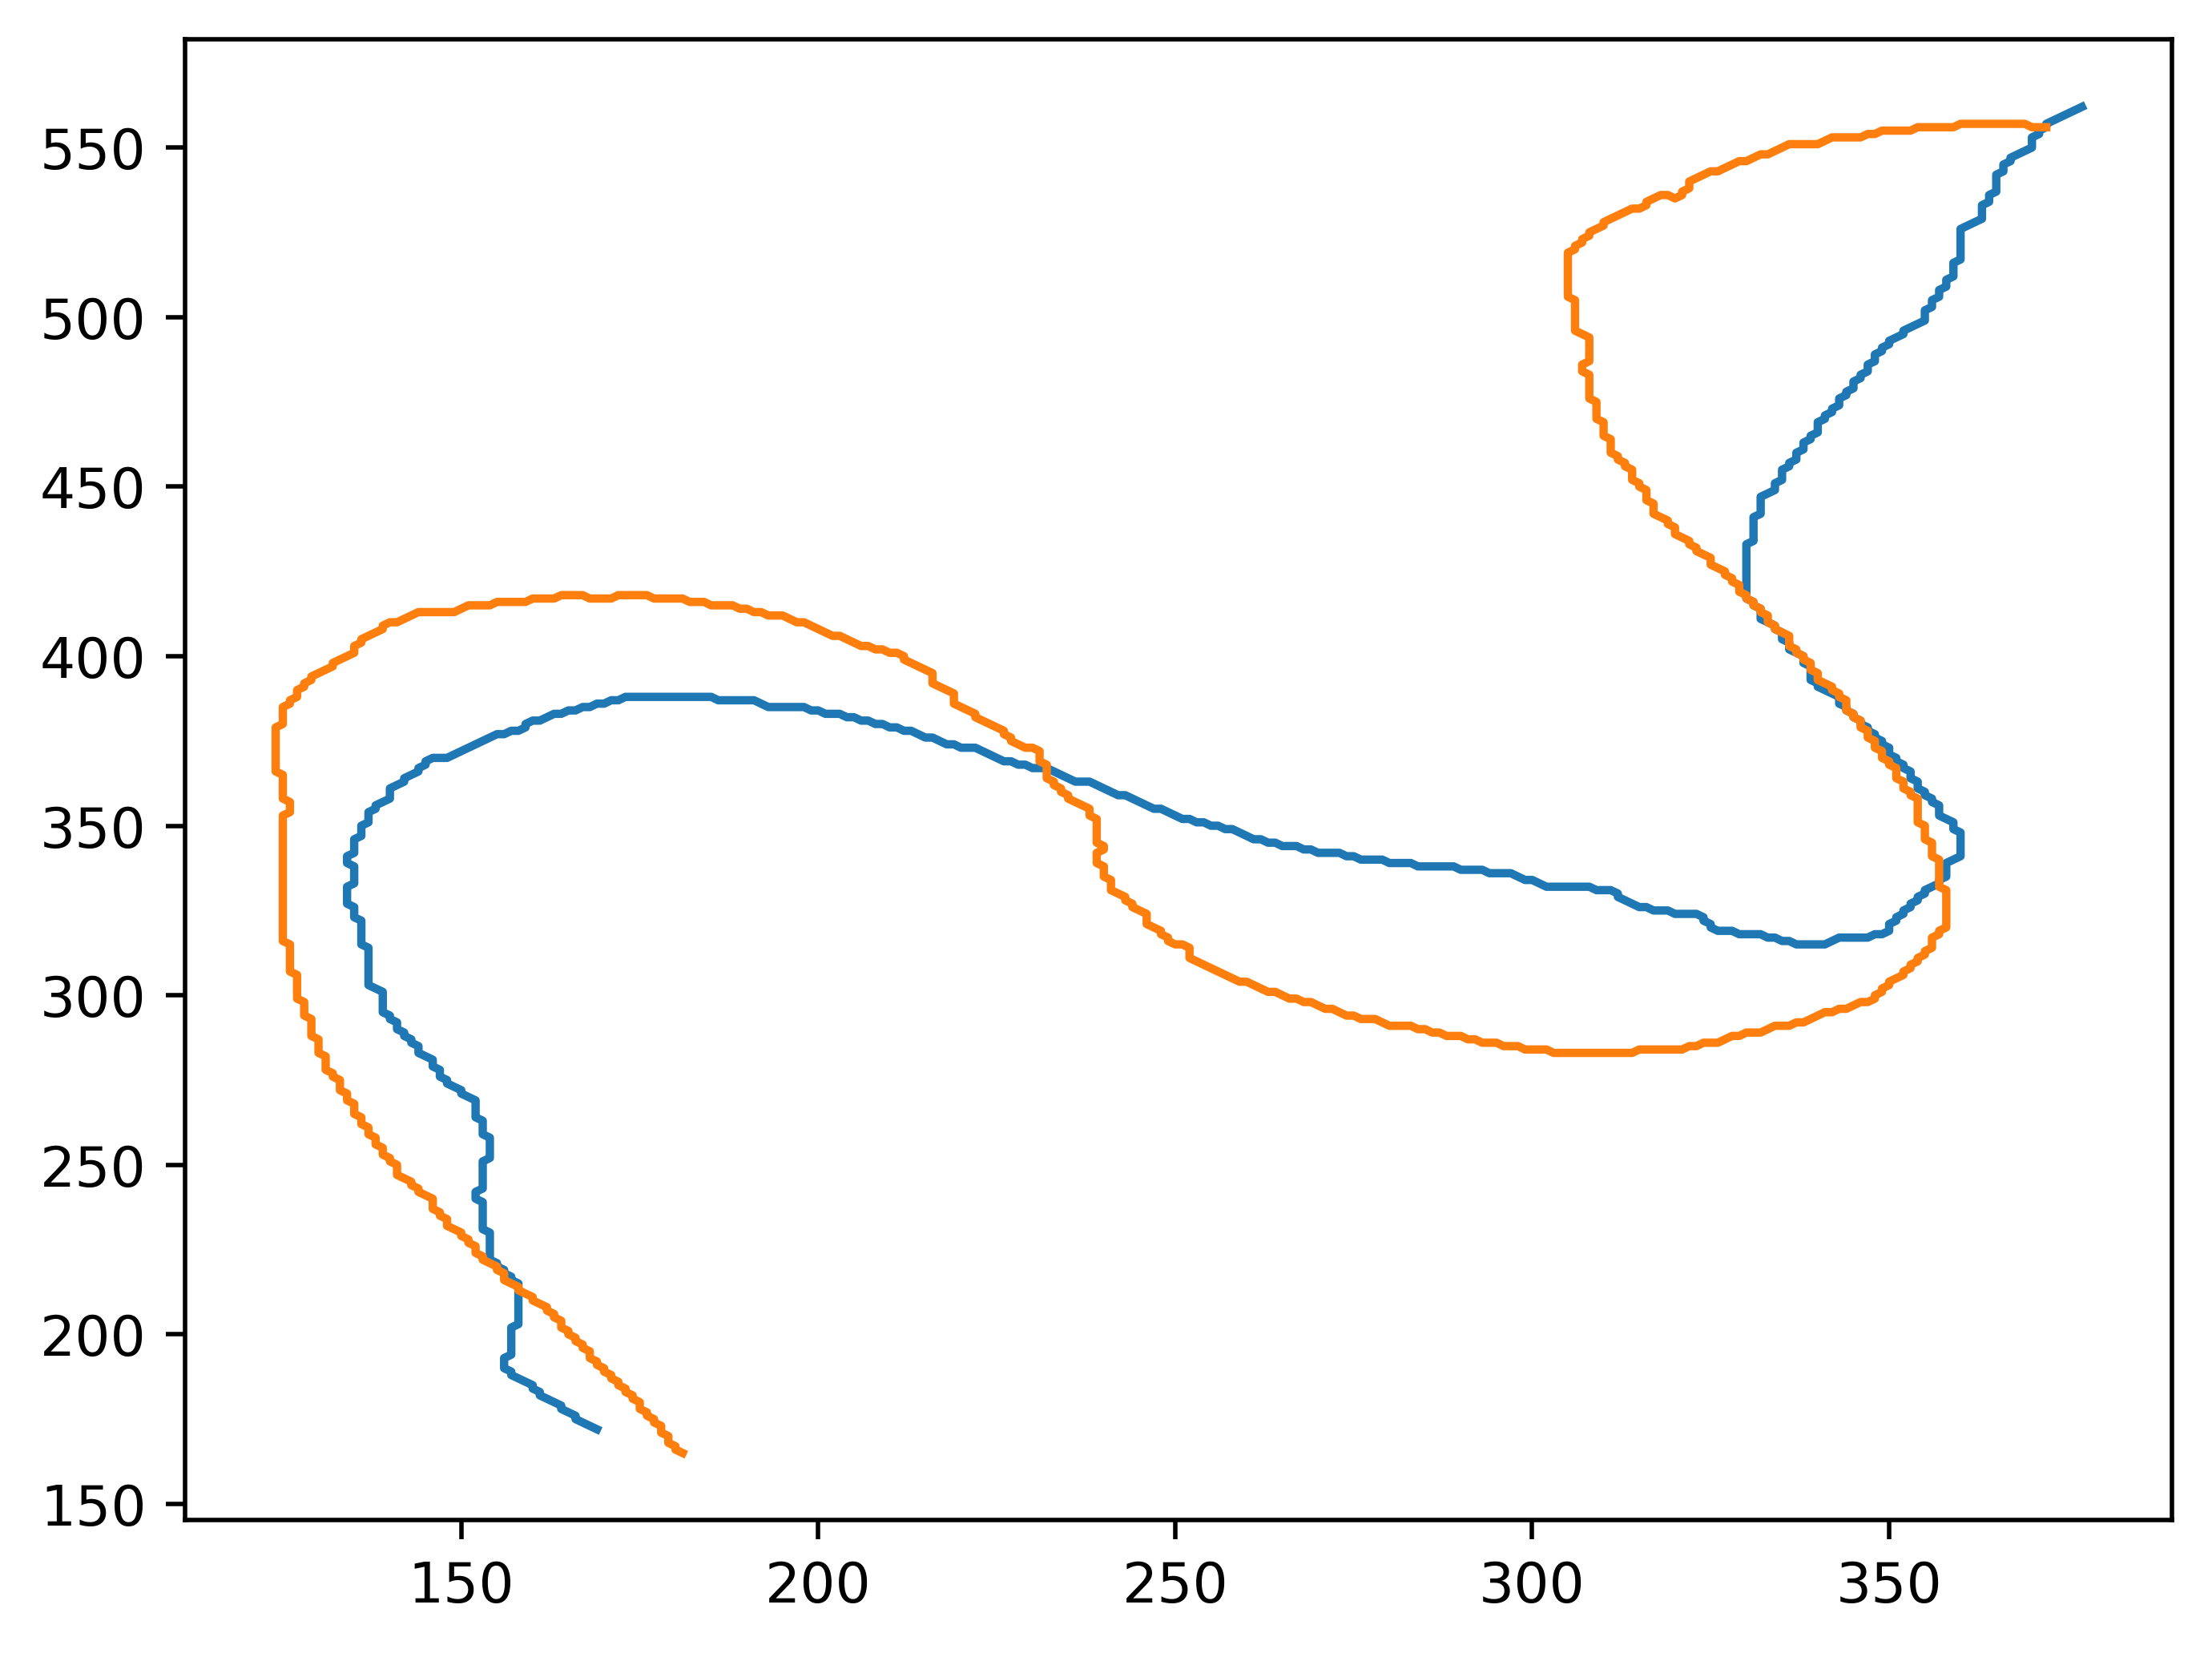

In [2]:
os.chdir(r"/Users/StatMeanderpyGithub/ChannelGeometry/2Bends")
cl1=np.loadtxt('0year.txt',delimiter=' ')
cl2=np.loadtxt('10year.txt',delimiter=' ')

xin = cl1[:,1][::-1]
yin = cl1[:,0][::-1]
xfi= cl2[:,1][::-1]
yfi = cl2[:,0][::-1]
plt.plot(xin,yin,label = 'Initial Channel')
plt.plot(xfi,yfi,label = 'Final Channel')

In [3]:
nit = 100                         # number of iterations
W = 100.0                         # channel width (m)
D = 10.0                          # channel depth (m)
depths = D * np.ones((nit,))      # channel depths for different iterations  
pad = 0                           # padding (number of nodepoints along centerline)
deltas = 50.0                     # sampling distance along centerline           
Cfs = 0.02 * np.ones((nit,))      #chezy friction factor
crdist = 1.8 * W                  # threshold distance at which cutoffs occur
kl = 200/(365*24*60*60.0)         # migration rate constant (m/s)
kv =  1.0e-12                     # vertical slope-dependent erosion rate constant (m/s)
dt = 0.1*(365*24*60*60.0)         # time step (s)
dens = 1000                       # density of water (kg/m^3)
saved_ts = 1                      # which time steps will be saved
Sl = 0.0                          # initial slope (matters more for submarine channels than rivers)
t1 = 0                            # time step when incision starts
t2 = 0                            # time step when lateral migration starts
t3 = 1200                         # time step when aggradation starts
aggr_factor = 2e-9                # aggradation factor (m/s, about 0.18 m/year, it kicks in after t3) after t3)
x=cl1[:,1]*10                     # initial x channel geometry
y=cl1[:,0]*10                     # initial y channel geometry
z=np.zeros(len(x))                # initial z (0)
H=depths[0]                       # no height in channel

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 135.70it/s]
/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/1963673883.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  simx = 0.1*chb.channels[np.int(nit-1)].x
/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/1963673883.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.

<Axes: xlabel='x'>

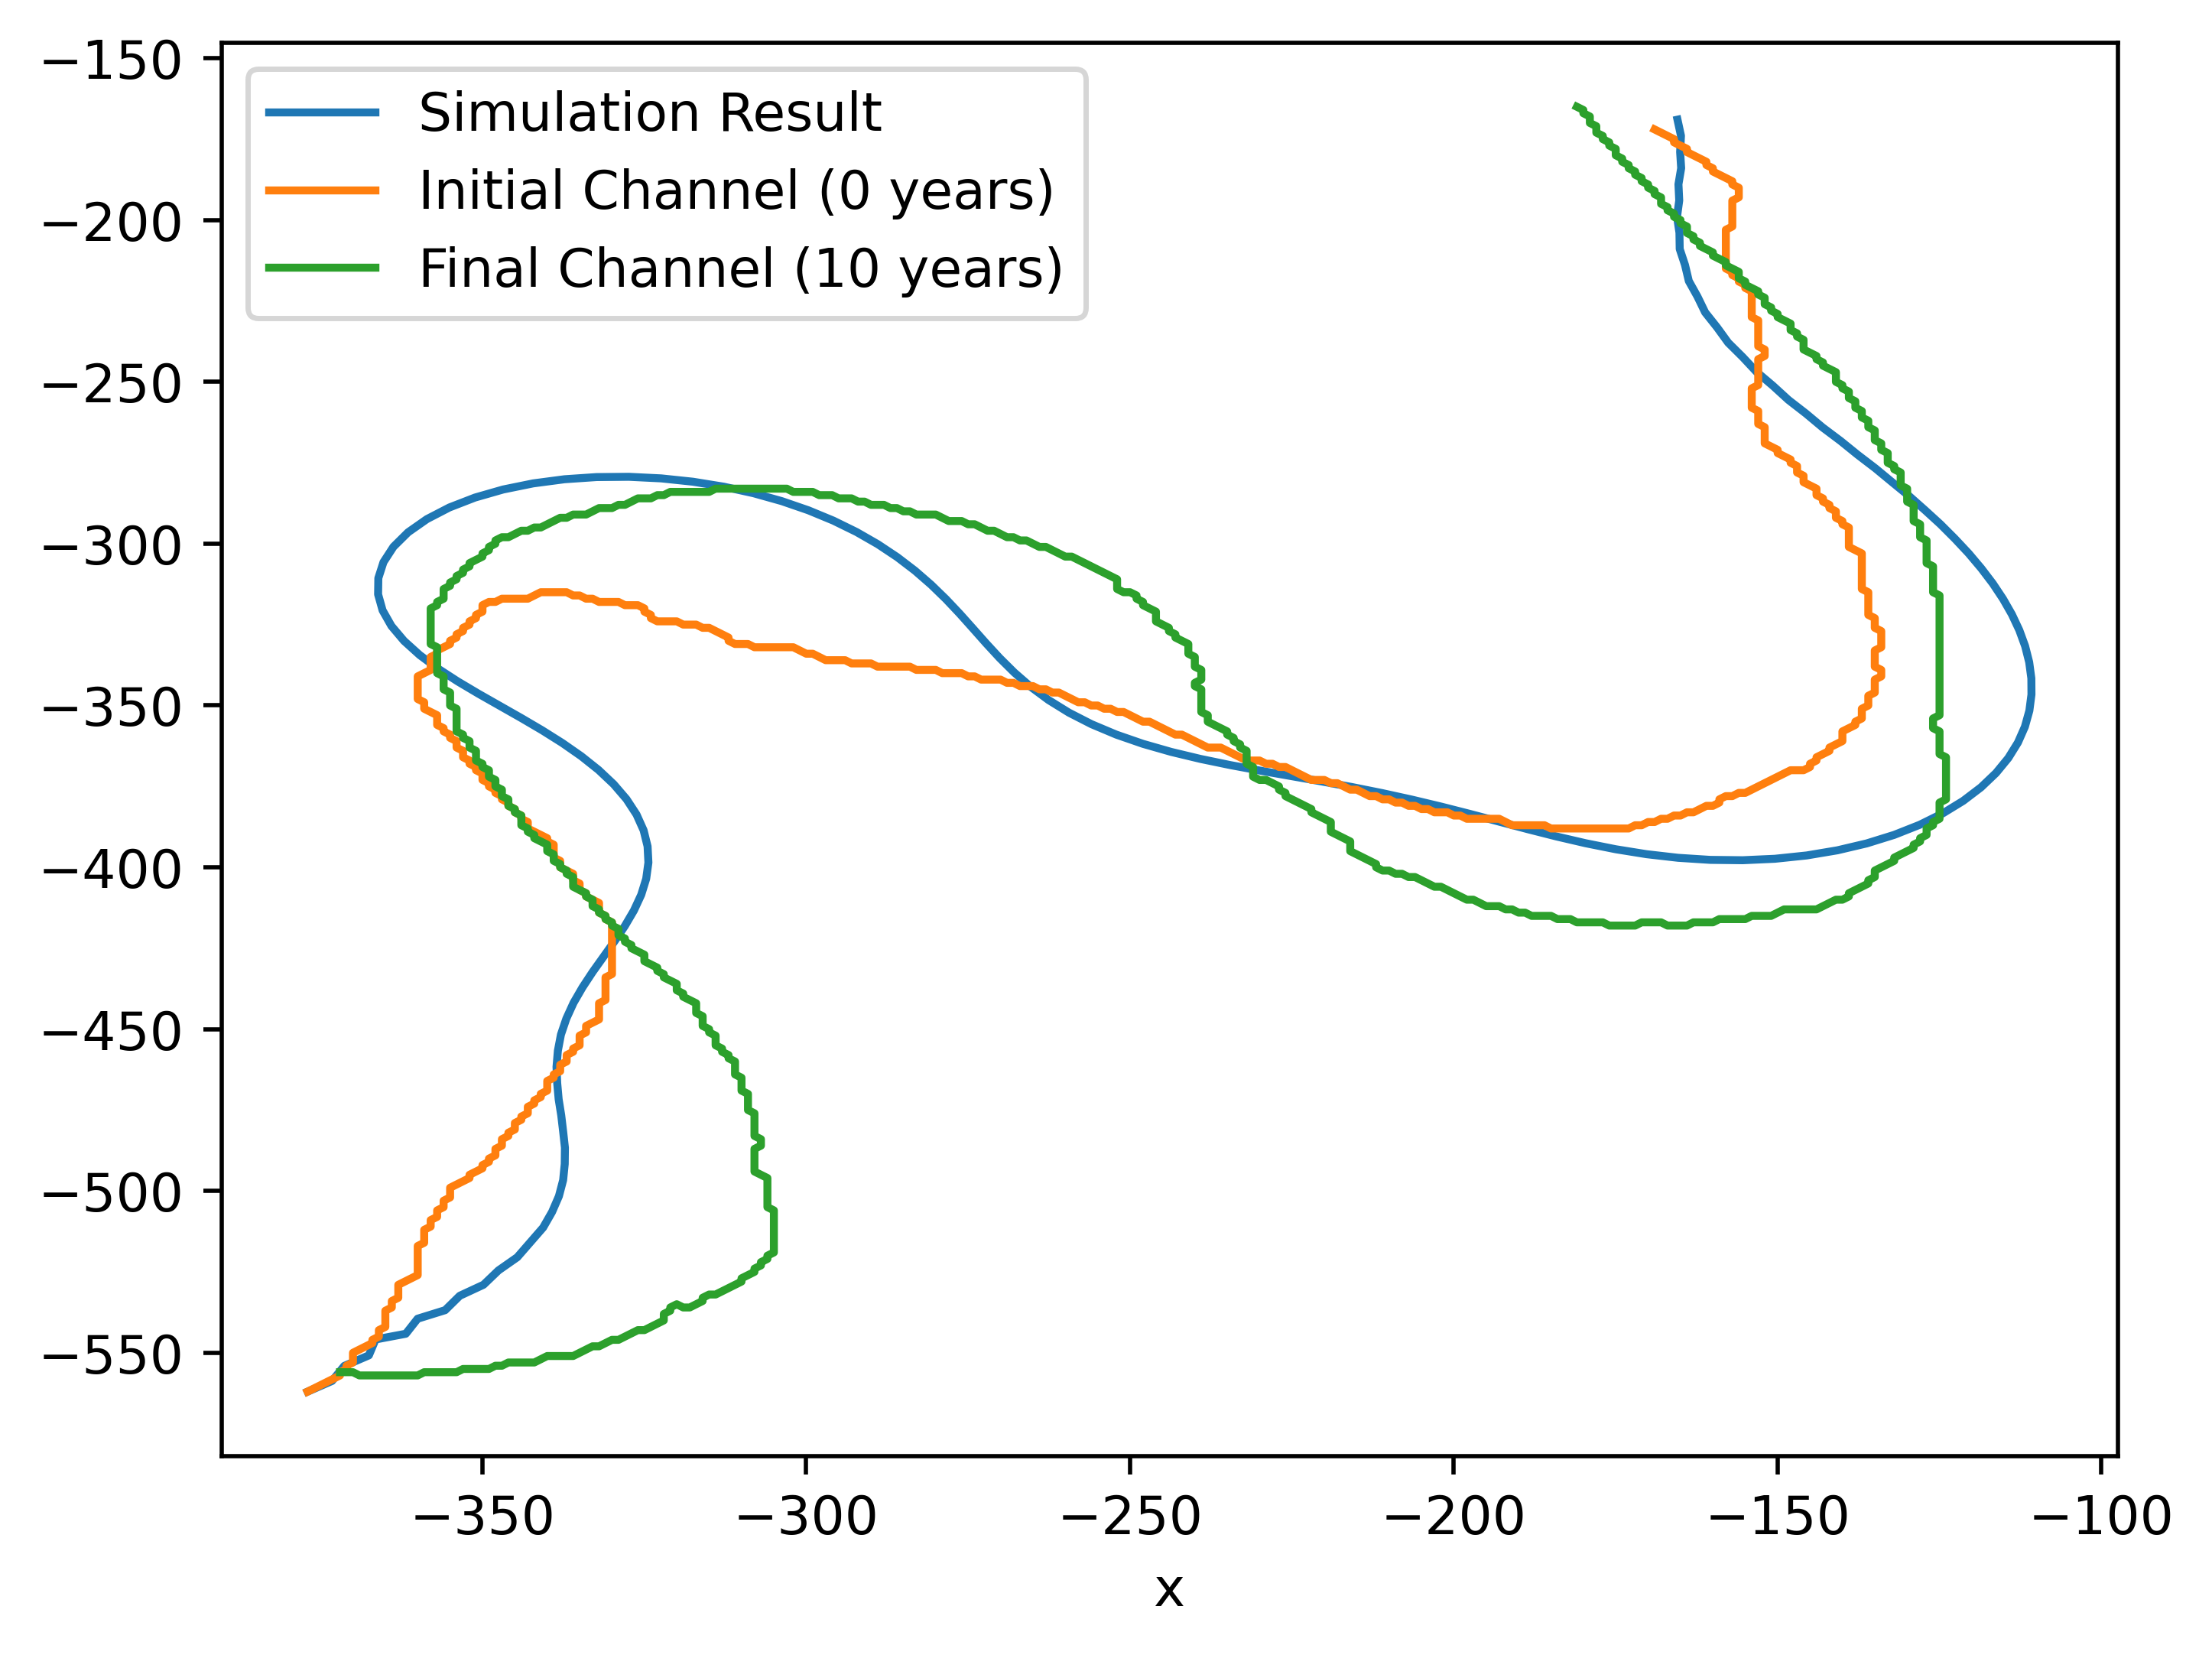

In [4]:
ch=mp.Channel(-x,-y,z,W,H)
chb=mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[])
chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor) # channel migration
channel_coordinate = pd.DataFrame({"x":chb.channels[nit-1].x, "y":chb.channels[nit-1].y, "Z":chb.channels[nit-1].z}) # the way it work is this: chb.channels[i].x will give you the x coordinates for the ith time step

simx = 0.1*chb.channels[np.int(nit-1)].x
simy = 0.1*chb.channels[np.int(nit-1)].y

ax = pd.DataFrame({"x":simx, "y":simy}).plot.line(x='x', y='y', label='Simulation Result')
pd.DataFrame({"x":-cl1[:,1], "y":-cl1[:,0]}).plot.line(x='x', y='y', ax= ax, label='Initial Channel (0 years)')
pd.DataFrame({"x":-cl2[:,1], "y":-cl2[:,0]}).plot.line(x='x', y='y', ax= ax, label='Final Channel (10 years)')

In [5]:
# Interpolating the initial channel
t = np.linspace(0,1,np.shape(cl1[:,])[0]) 
x_o = -cl1[:,1].flatten()           
y_o = -cl1[:,0].flatten()         
fx_o = interpolate.interp1d(t,x_o)     
fy_o = interpolate.interp1d(t, y_o)    
tnew = np.linspace(0,1,1000)   
xnew_o = fx_o(tnew) + np.random.normal(0,0.1,1000)  
ynew_o = fy_o(tnew) + np.random.normal(0,0.1,1000)
xnew_o = fx_o(tnew)
ynew_o = fy_o(tnew)  
data_obs_ins = np.array([xnew_o,ynew_o])
data_obs_ins = np.round(data_obs_ins, 2) 
# Interpolating the final channel
t = np.linspace(0,1,np.shape(cl2[:,])[0]) 
x_o = -cl2[:,1].flatten()          
y_o = -cl2[:,0].flatten()           
fx_o = interpolate.interp1d(t,x_o)    
fy_o = interpolate.interp1d(t, y_o)    
tnew = np.linspace(0,1,1000)          
xnew_o = fx_o(tnew)                   
ynew_o = fy_o(tnew)
data_obs = np.array([xnew_o,ynew_o])
data_obs = np.round(data_obs, 1)
# Interpolating the simulated channel
t = np.linspace(0,1,np.shape(0.1*chb.channels[np.int(nit-1)].x)[0])
x_m = 0.1*chb.channels[np.int(nit-1)].x
y_m = 0.1*chb.channels[np.int(nit-1)].y
fx_m = interpolate.interp1d(t,x_m)
fy_m = interpolate.interp1d(t, y_m)
tnew = np.linspace(0,1,1000)
xnew_m = fx_m(tnew)
ynew_m = fy_m(tnew)
ynew_ms = ynew_m+np.random.normal(loc=0.0, scale= 0.1, size=1)
xnew_ms = xnew_m+np.random.normal(loc=0.0, scale= 0.1, size=1)
ynew_ms = ynew_m
xnew_ms = xnew_m

/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/54679243.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t = np.linspace(0,1,np.shape(0.1*chb.channels[np.int(nit-1)].x)[0])
/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/54679243.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If

In [6]:
nit = 100                   
depths = D * np.ones((nit,)) 
pad = 0                 
deltas = 50.0               
crdist = 1.8 * W              
kv =  1.0e-12             
dt = 0.1*(365*24*60*60.0)    
dens = 1000               
saved_ts = 1              
n_bends = 5              
Sl = 0.0            
t1 = 0                  
t2 = 0                  
t3 = 0      

def hkm(parm):  
    kl =  (parm[0]*10)/(365*24*60*60.0)  
    Cfs = parm[1] * 0.001 * np.ones((nit,))
    y=cl1[:,0]*10
    x=cl1[:,1]*10
    z=np.zeros(len(x))
    H=depths[0]
    
    try:    
        ch=mp.Channel(-x,-y,z,W,H)
        chb=mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[])
        ch = mp.generate_initial_channel(W,D,Sl,deltas,pad,n_bends)
        chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor)
        
        if np.shape(0.1*chb.channels[np.int(nit-1)].x)[0] < 1000:
            t = np.linspace(0,1,np.shape(0.1*chb.channels[np.int(nit-1)].x)[0])
            x_m = 0.1*chb.channels[np.int(nit-1)].x
            y_m = 0.1*chb.channels[np.int(nit-1)].y
            fx_m = interpolate.interp1d(t,x_m)
            fy_m = interpolate.interp1d(t, y_m)
            tnew = np.linspace(0,1,1000)
            xnew_m = fx_m(tnew) 
            ynew_m = fy_m(tnew) 
            xnew_m[:] = xnew_m[::-1] 
            ynew_m[:] = ynew_m[::-1] 
        
        else:
            t = np.linspace(0,1,1000)
            xnew_m = np.zeros(1000) 
            ynew_m = np.zeros(1000) 
            ynew_m[:] = ynew_m[::-1] 
            xnew_m[:] = xnew_m[::-1] 

    except:
        t = np.linspace(0,1,1000)
        xnew_m = np.zeros(1000) 
        ynew_m = np.zeros(1000) 
        ynew_m[:] = ynew_m[::-1] 
        xnew_m[:] = xnew_m[::-1] 
        
    return np.array([xnew_m,ynew_m])

[15 20  1]
[15 20  1]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1348.75it/s]
/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/2547357711.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.shape(0.1*chb.channels[np.int(nit-1)].x)[0] < 1000:
/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/2547357711.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you

-4467.466405946634

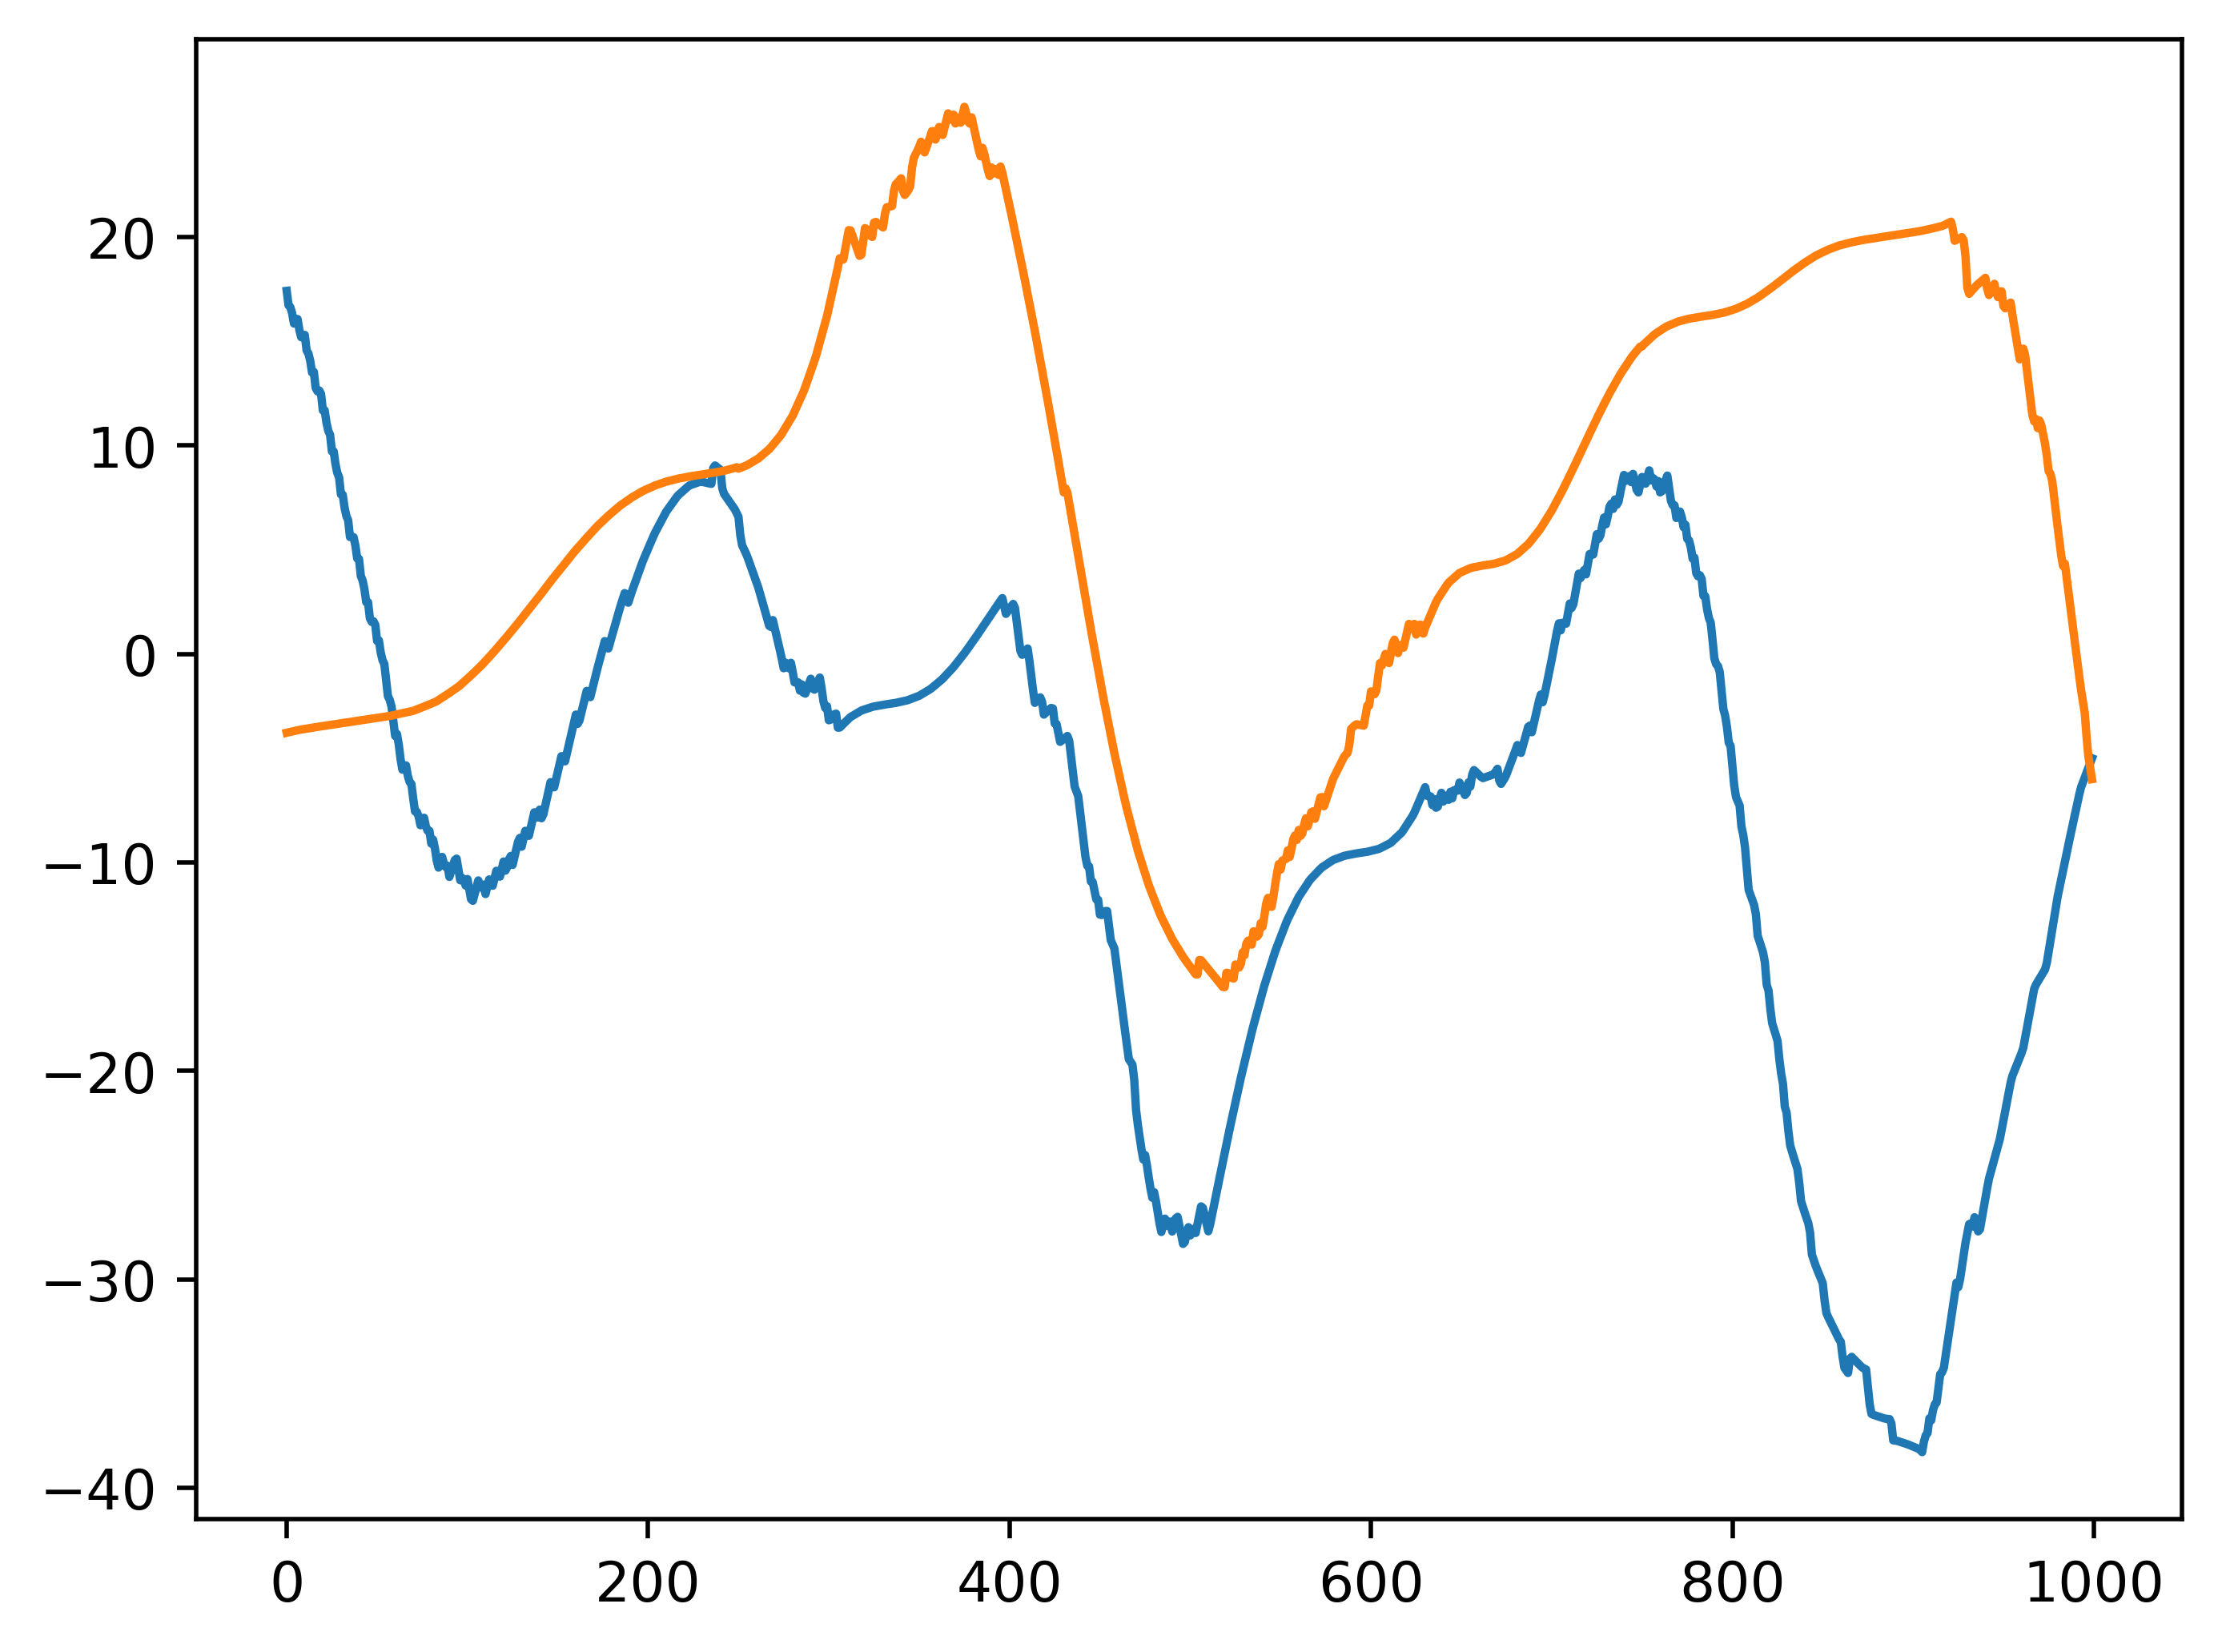

In [7]:
def log_prior(par):
    # par[0] is migration rate (kl) par[1] is chezy friction factor (Cfs) and par[2] is error term
    if  10 < par[0] < 50 and 0 < par[1] < 30 and 0.01 < par[2] < 10:  
        return -par[2]/1                                               
    else:
        return -np.inf
    
def log_lik(par,data):
    print(par)
    sim = hkm(parm=par[:2])
    
    x_err = sim[0,:]-data[0,:][::-1]
    y_err = sim[1,:]-data[1,:][::-1]
    plt.plot(x_err) 
    plt.plot(y_err) 

    y_fft = np.fft.fft(y_err)  
    x_fft = np.fft.fft(x_err) 
    
    y_amp1 = 2*abs(y_fft.real/y_fft.size)    
    y_amp2 = 2*abs(y_fft.imag/y_fft.size)     
    x_amp1 = 2*abs(x_fft.real/x_fft.size)    
    x_amp2 = 2*abs(x_fft.imag/x_fft.size)    
    
    amp = np.array([y_amp1,y_amp2,x_amp1,x_amp2]) 
    
    return np.sum(np.log(stats.norm.pdf(amp, loc=0, scale=par[2])))

def log_post(par, data):
    par = np.around(par, decimals = 0)
    print (par)
    if (log_prior(par)==-np.inf):
        lp = log_prior(par)
    else: 
        lp = log_lik(par,data)+ log_prior(par)
    return lp  

#test run [kl, Cfs, error term]
log_post([15,20 ,1],data_obs)

[2. 2. 2.]
[24. 10.  1.]
[24. 10.  1.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1352.85it/s]
/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/2547357711.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.shape(0.1*chb.channels[np.int(nit-1)].x)[0] < 1000:
/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/2547357711.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you

[7. 4. 3.]
[10.  5.  1.]
[8. 6. 2.]
[19.  4.  4.]
[19.  4.  4.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1434.89it/s]


[12.  8.  1.]
[12.  8.  1.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1415.13it/s]


[20.  9.  3.]
[20.  9.  3.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1393.73it/s]


[26.  2.  4.]
[26.  2.  4.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1431.84it/s]


[ 2. 16.  3.]
[12.  6.  0.]
[9. 7. 1.]
[13.  7.  1.]
[13.  7.  1.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1402.84it/s]


[39. 16.  3.]
[39. 16.  3.]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 986.59it/s]


[24.  2.  4.]
[24.  2.  4.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1378.30it/s]
/Users/braydennoh/anaconda3/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


[0. 1. 3.]
[17.  8.  2.]
[17.  8.  2.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1366.16it/s]


[7. 3. 3.]
[19.  4.  4.]
[19.  4.  4.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1427.06it/s]


[ 9. 12.  3.]
[24. 10.  1.]
[24. 10.  1.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1344.14it/s]


[6. 3. 3.]
[22.  9.  3.]
[22.  9.  3.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1405.17it/s]


[27.  1.  3.]
[27.  1.  3.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1417.52it/s]


[-7. 22.  3.]
[-4. -1.  3.]
[14.  7.  1.]
[14.  7.  1.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1373.10it/s]


[ 5. 11.  2.]
[20.  5.  3.]
[20.  5.  3.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1328.66it/s]


[13.  8.  1.]
[13.  8.  1.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1374.15it/s]


[-4. -1.  3.]
[28. 12.  1.]
[28. 12.  1.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1312.01it/s]


[8. 6. 2.]
[25. 10.  4.]
[25. 10.  4.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1375.97it/s]


[ 6. 13.  3.]
[6. 2. 4.]
[18.  3.  0.]
[24.  5.  4.]
[24.  5.  4.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1307.08it/s]


[9. 6. 2.]
[23.  4.  3.]
[23.  4.  3.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1312.51it/s]


[9. 3. 3.]
[-3.  3.  3.]
[12.  8.  1.]
[12.  8.  1.]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 912.02it/s]


[8. 6. 2.]
[24. -2.  4.]
[17.  8.  2.]
[17.  8.  2.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1328.02it/s]


[20.  5.  3.]
[20.  5.  3.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1345.35it/s]


[17. 11.  0.]
[22.  7.  3.]
[22.  7.  3.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1271.96it/s]


[-1. 21.  4.]
[1. 1. 2.]
[10.  6.  2.]
[5. 4. 2.]
[25.  3.  4.]
[25.  3.  4.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1281.67it/s]


[-9. 19.  4.]
[21. 10.  2.]
[21. 10.  2.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1278.43it/s]


[6. 7. 3.]
[19.  6.  3.]
[19.  6.  3.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1313.66it/s]


[20. 12.  0.]
[21. 13.  3.]
[21. 13.  3.]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1315.79it/s]


array([[ 2.16683552,  1.57205135,  2.44197849],
       [23.89098823, 10.32481143,  1.45927093],
       [ 7.34078706,  3.91563256,  2.93373413],
       [10.3404697 ,  5.47787896,  1.10069101],
       [ 8.27811552,  5.80010791,  1.74606912],
       [19.35183213,  3.53153466,  3.85896853],
       [12.05398666,  8.08779323,  1.00605483],
       [20.40806254,  8.7498954 ,  2.81067329],
       [24.40562886,  1.95026524,  3.59335593],
       [ 1.88116918, 16.01795297,  3.0552828 ],
       [ 2.16683552,  1.57205135,  2.44197849],
       [23.91764501, 10.33555157,  1.45806509],
       [ 7.34078706,  3.91563256,  2.93373413],
       [13.64139538,  6.65889165,  1.18757692],
       [ 8.27811552,  5.80010791,  1.74606912],
       [20.25857052,  4.88276467,  3.38216595],
       [12.98069441,  8.26337272,  1.04136278],
       [21.84953052,  8.86413892,  3.1220542 ],
       [27.44925766,  0.99795209,  3.43339181],
       [ 1.88116918, 16.01795297,  3.0552828 ],
       [ 2.16683552,  1.57205135,  2.441

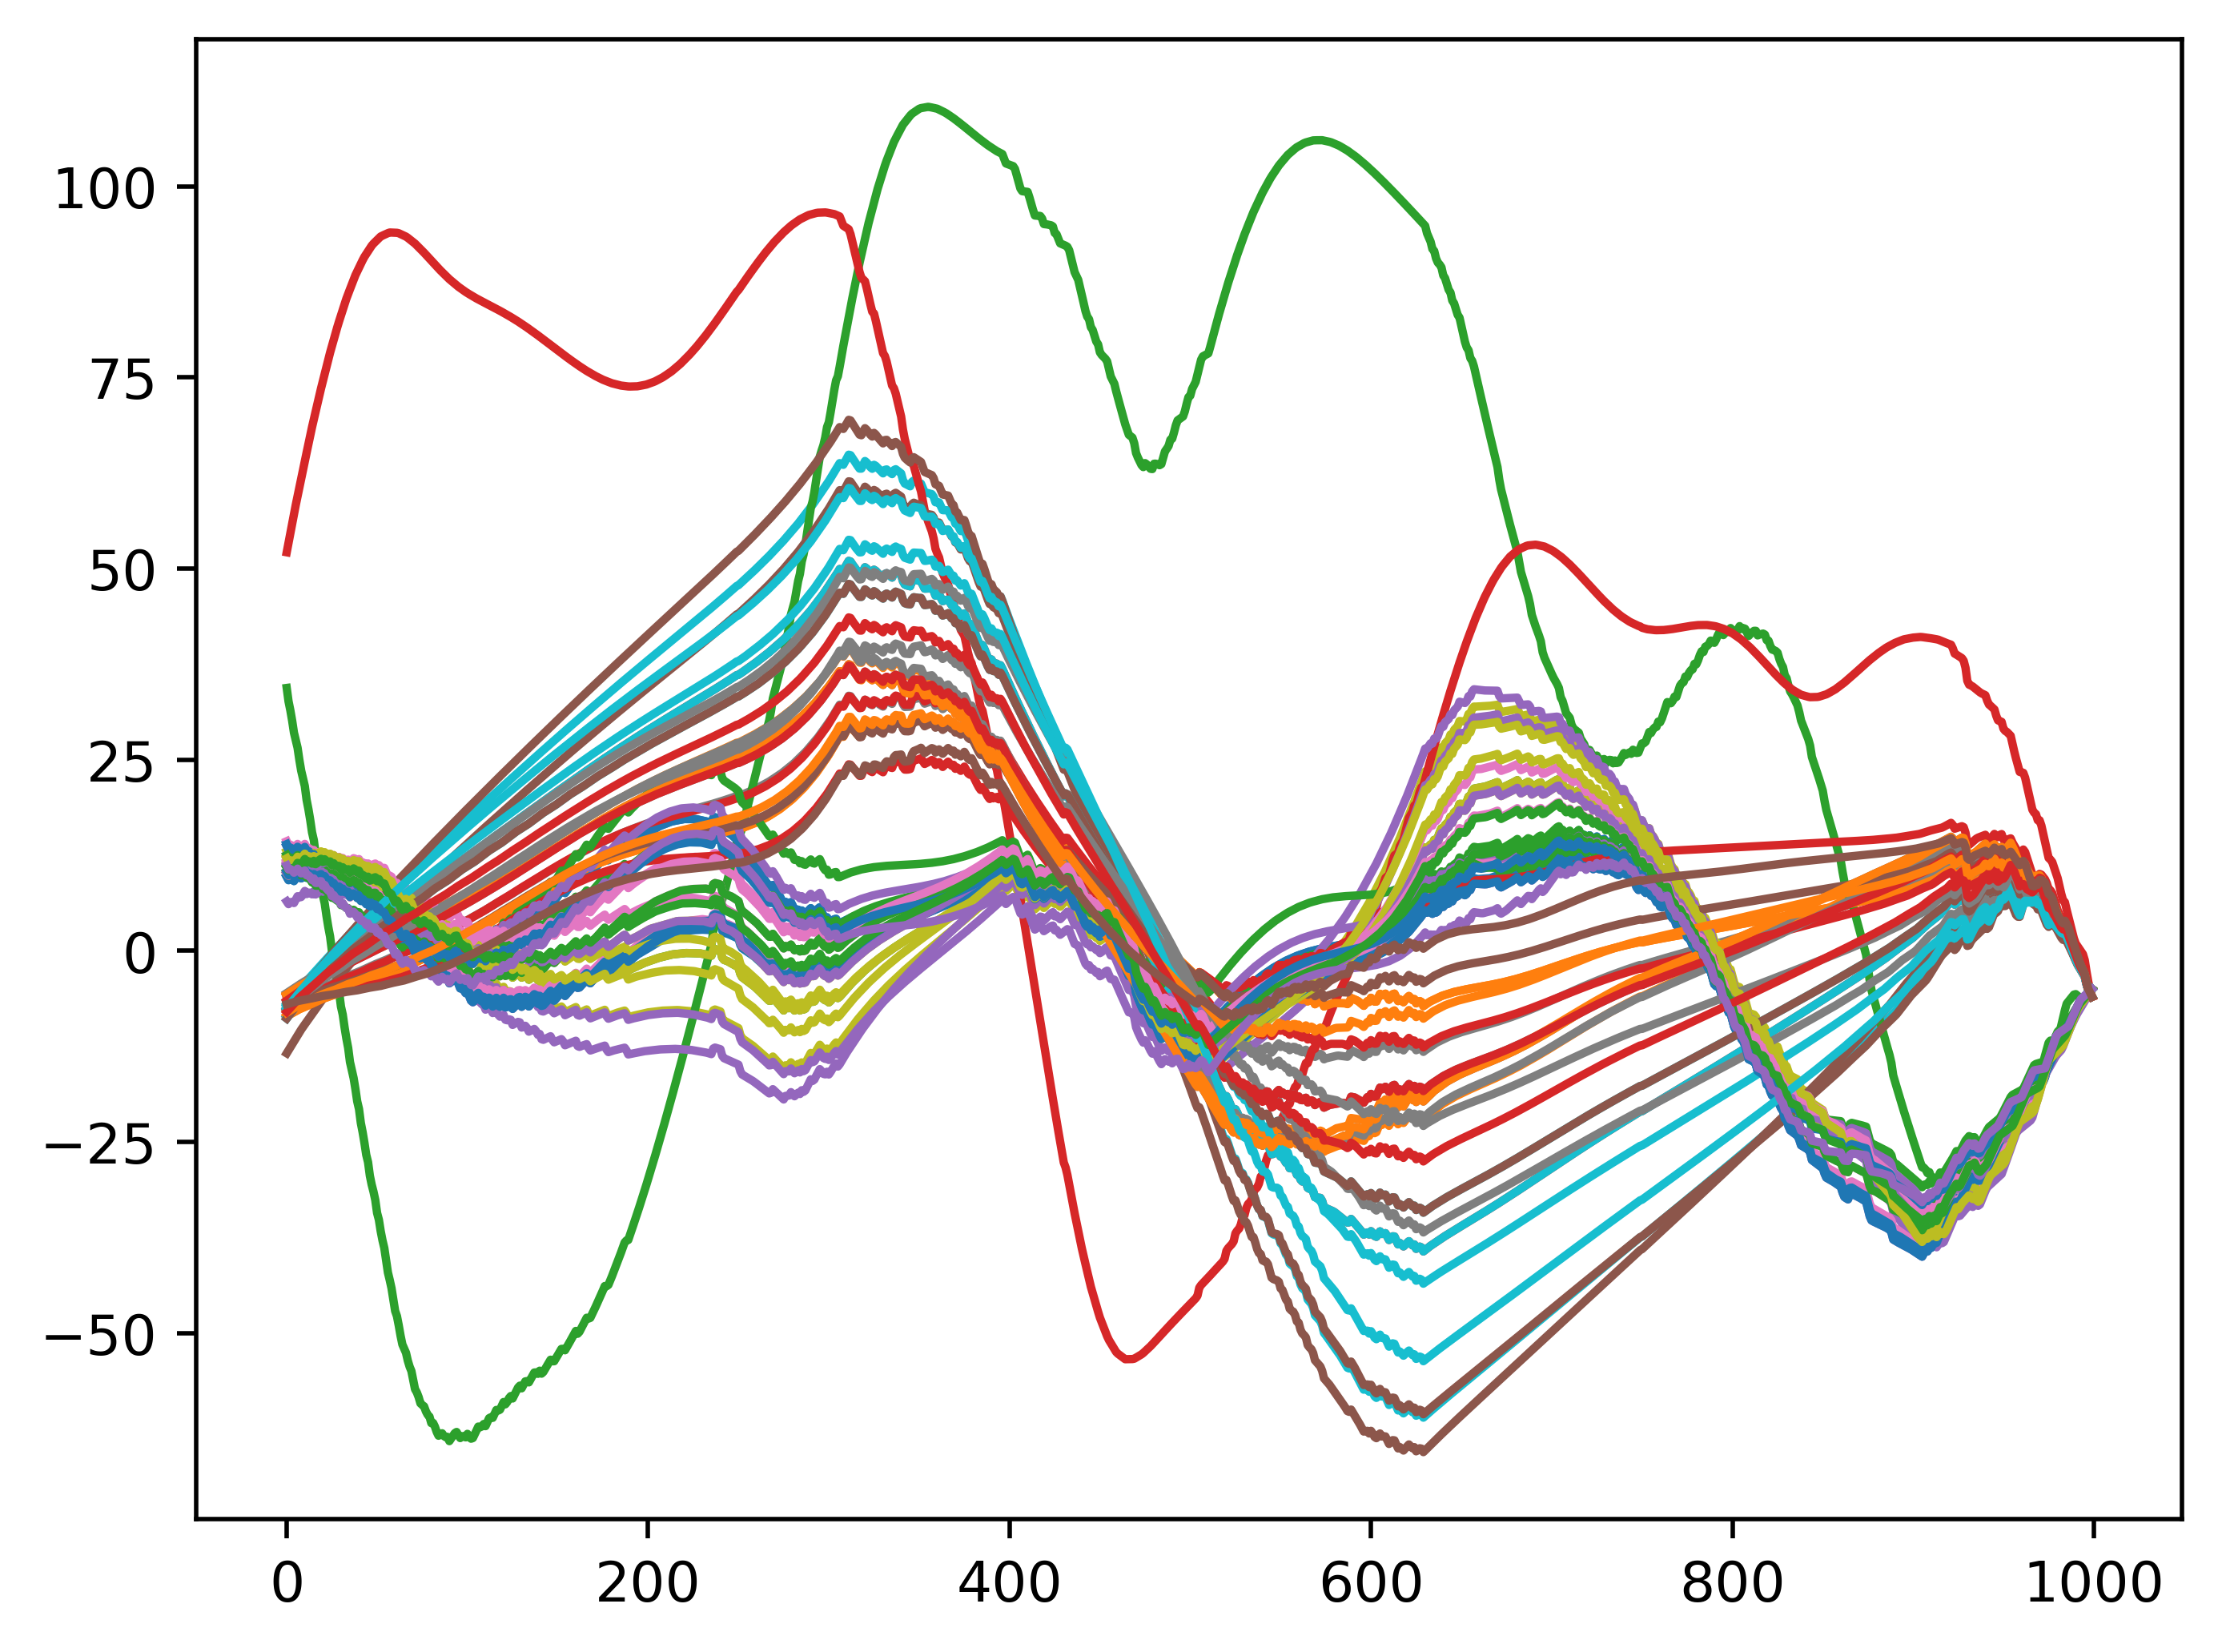

In [8]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

ndim, nwalkers = 3, 10

X1 = get_truncated_normal(mean=15, sd=10, low=1, upp=40)
X2 = get_truncated_normal(mean=10, sd=10, low=1, upp=20)
X3 = get_truncated_normal(mean=2, sd=1, low=1, upp=5)

p0 = np.ones([nwalkers, ndim])
p0[:,0] = X1.rvs(size = nwalkers)
p0[:,1] = X2.rvs(size = nwalkers)
p0[:,2] = X3.rvs(size = nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args = [data_obs])

samples_runs = 5

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args = [data_obs])
sampler.run_mcmc(p0, samples_runs) 
samp = sampler.get_chain()

samp_reshaped = samp.reshape(samp.shape[0], -1) #so that the 3D array is reshaped as 2D, to save it 
np.savetxt('samples_emcee.txt',samp_reshaped, delimiter=',')

sampsubset = samp[0:samples_runs,:,:]
samp2d = sampsubset.reshape(sampsubset.shape[0]*sampsubset.shape[1],3)
samp2d.shape
samp2d

Text(0.5, 0, 'MCMC Steps')

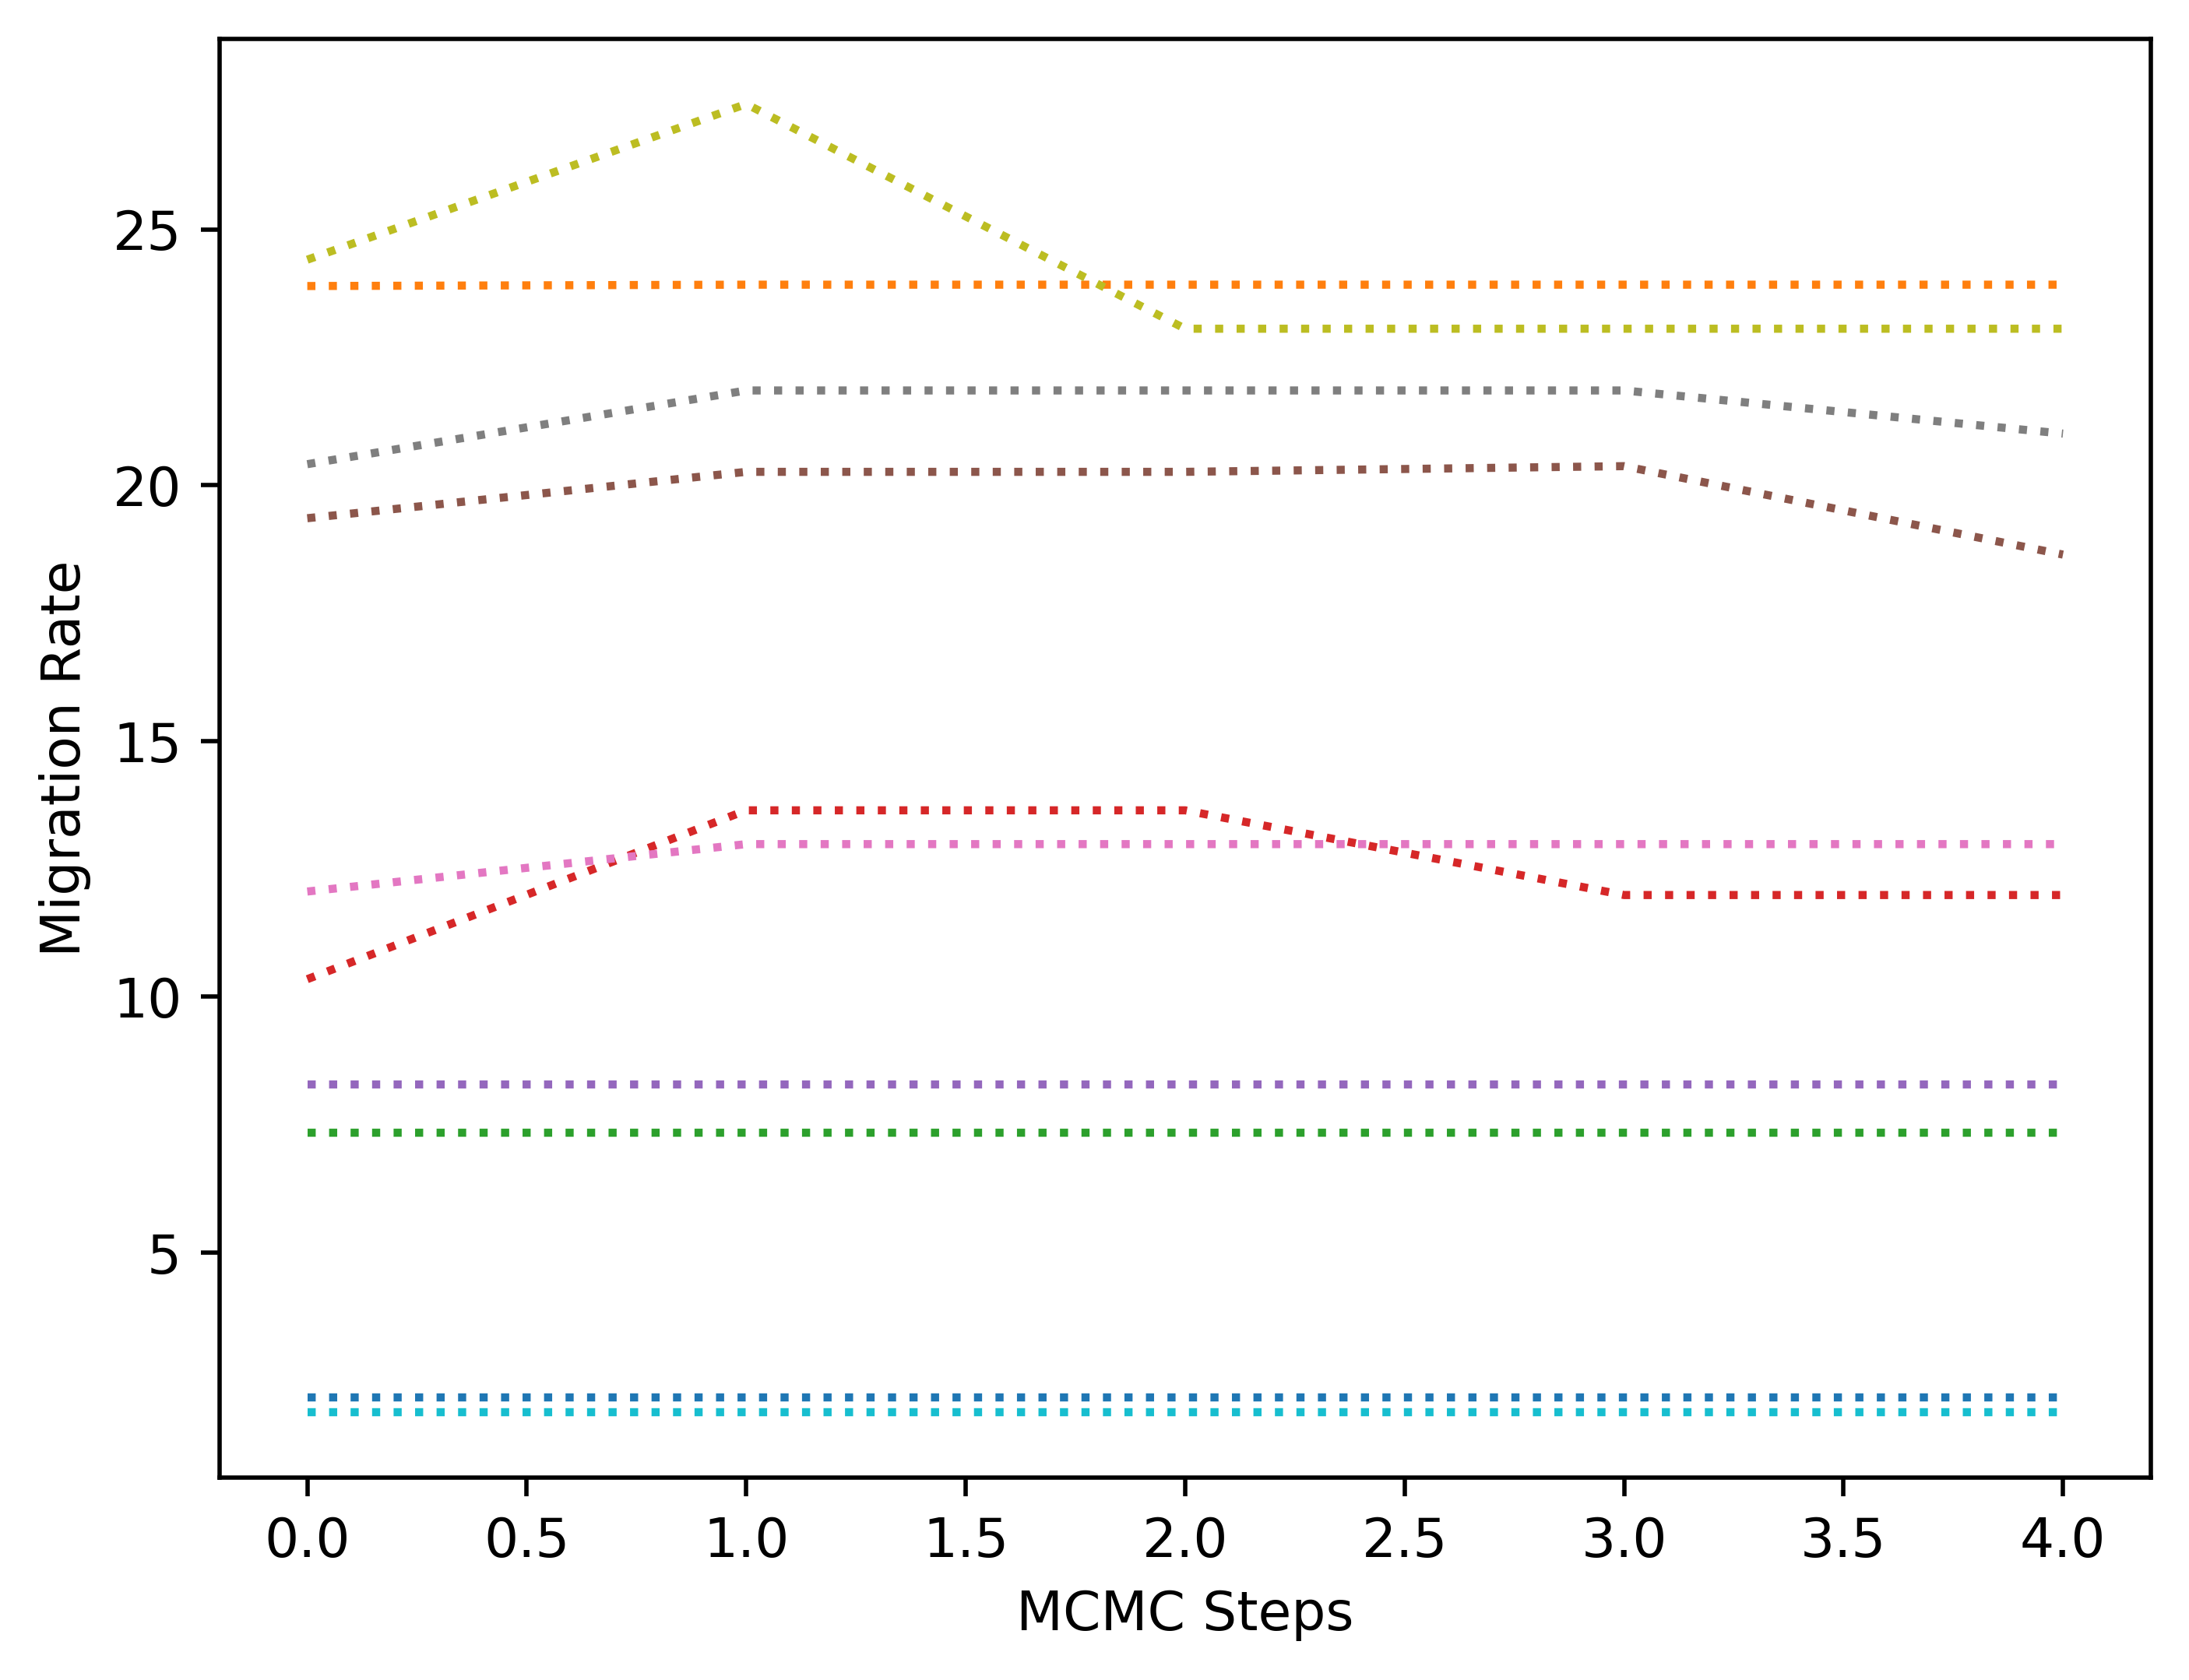

In [9]:
plt.plot(sampler.chain[:,:,0].T, ':')
plt.ylabel("Migration Rate",color='black')
plt.xlabel("MCMC Steps",color='black')

Text(0.5, 0, 'MCMC Steps')

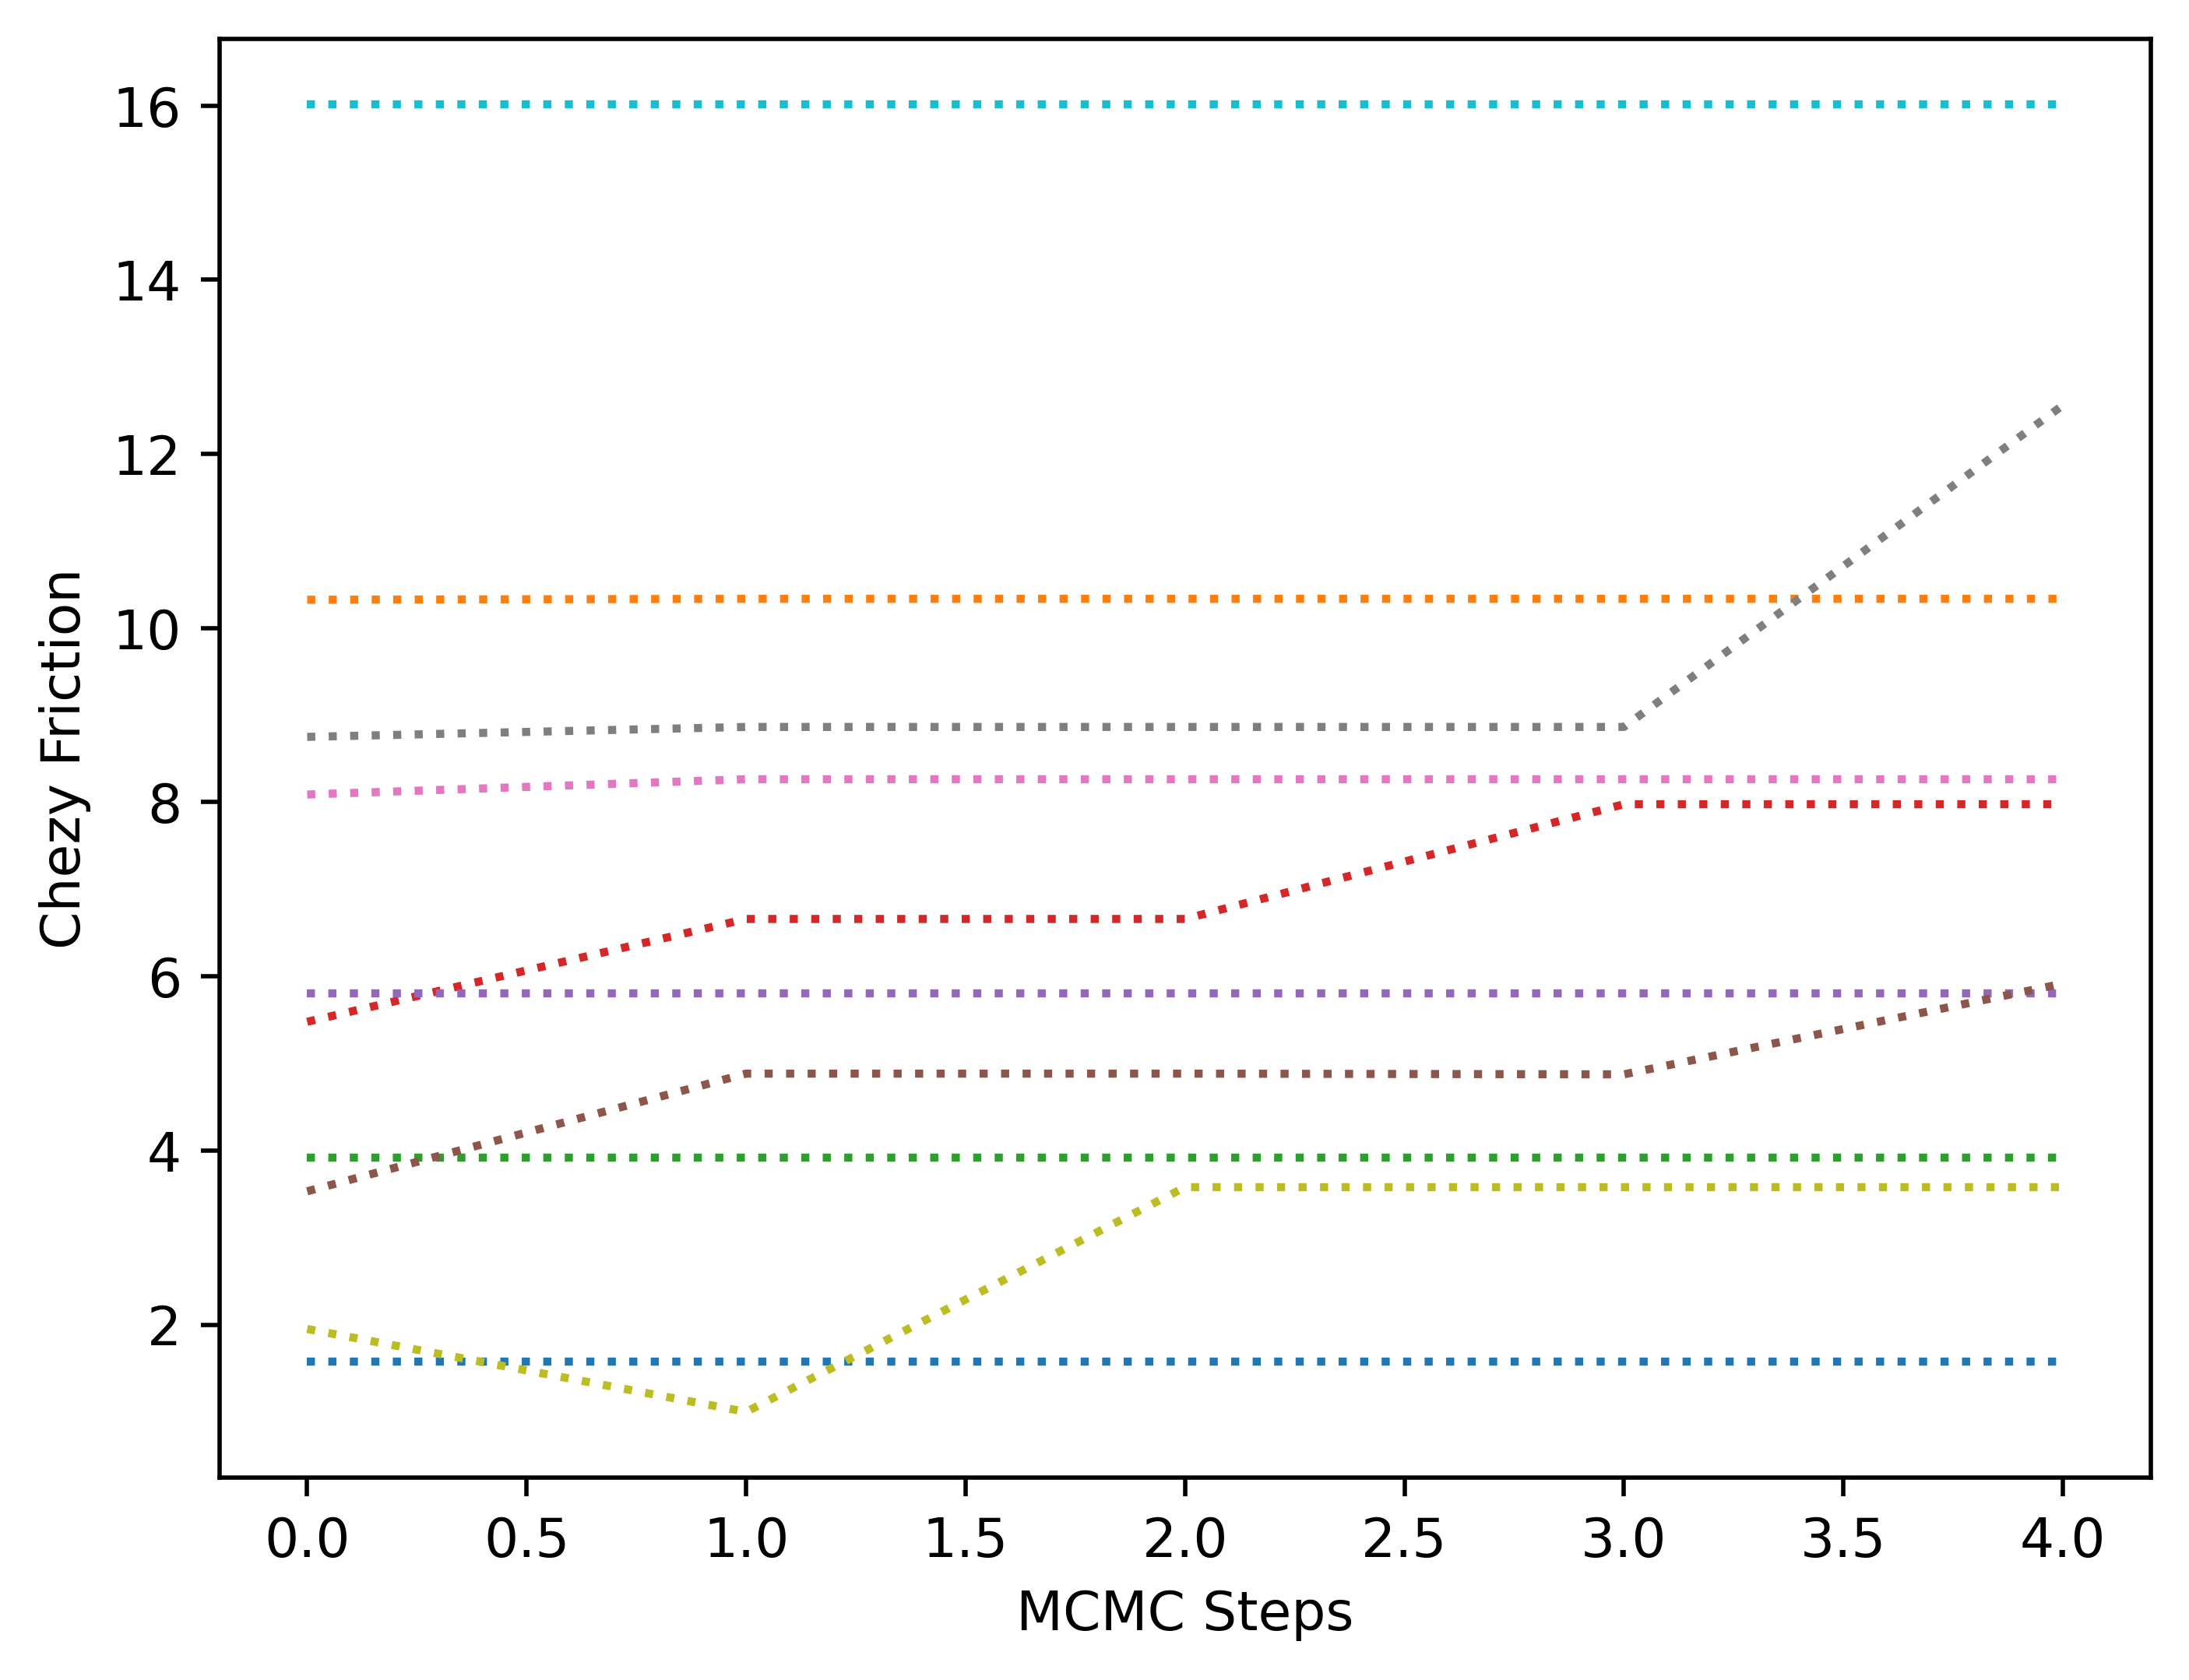

In [10]:
plt.plot(sampler.chain[:,:,1].T, ':')
plt.ylabel("Chezy Friction",color='black')
plt.xlabel("MCMC Steps",color='black')

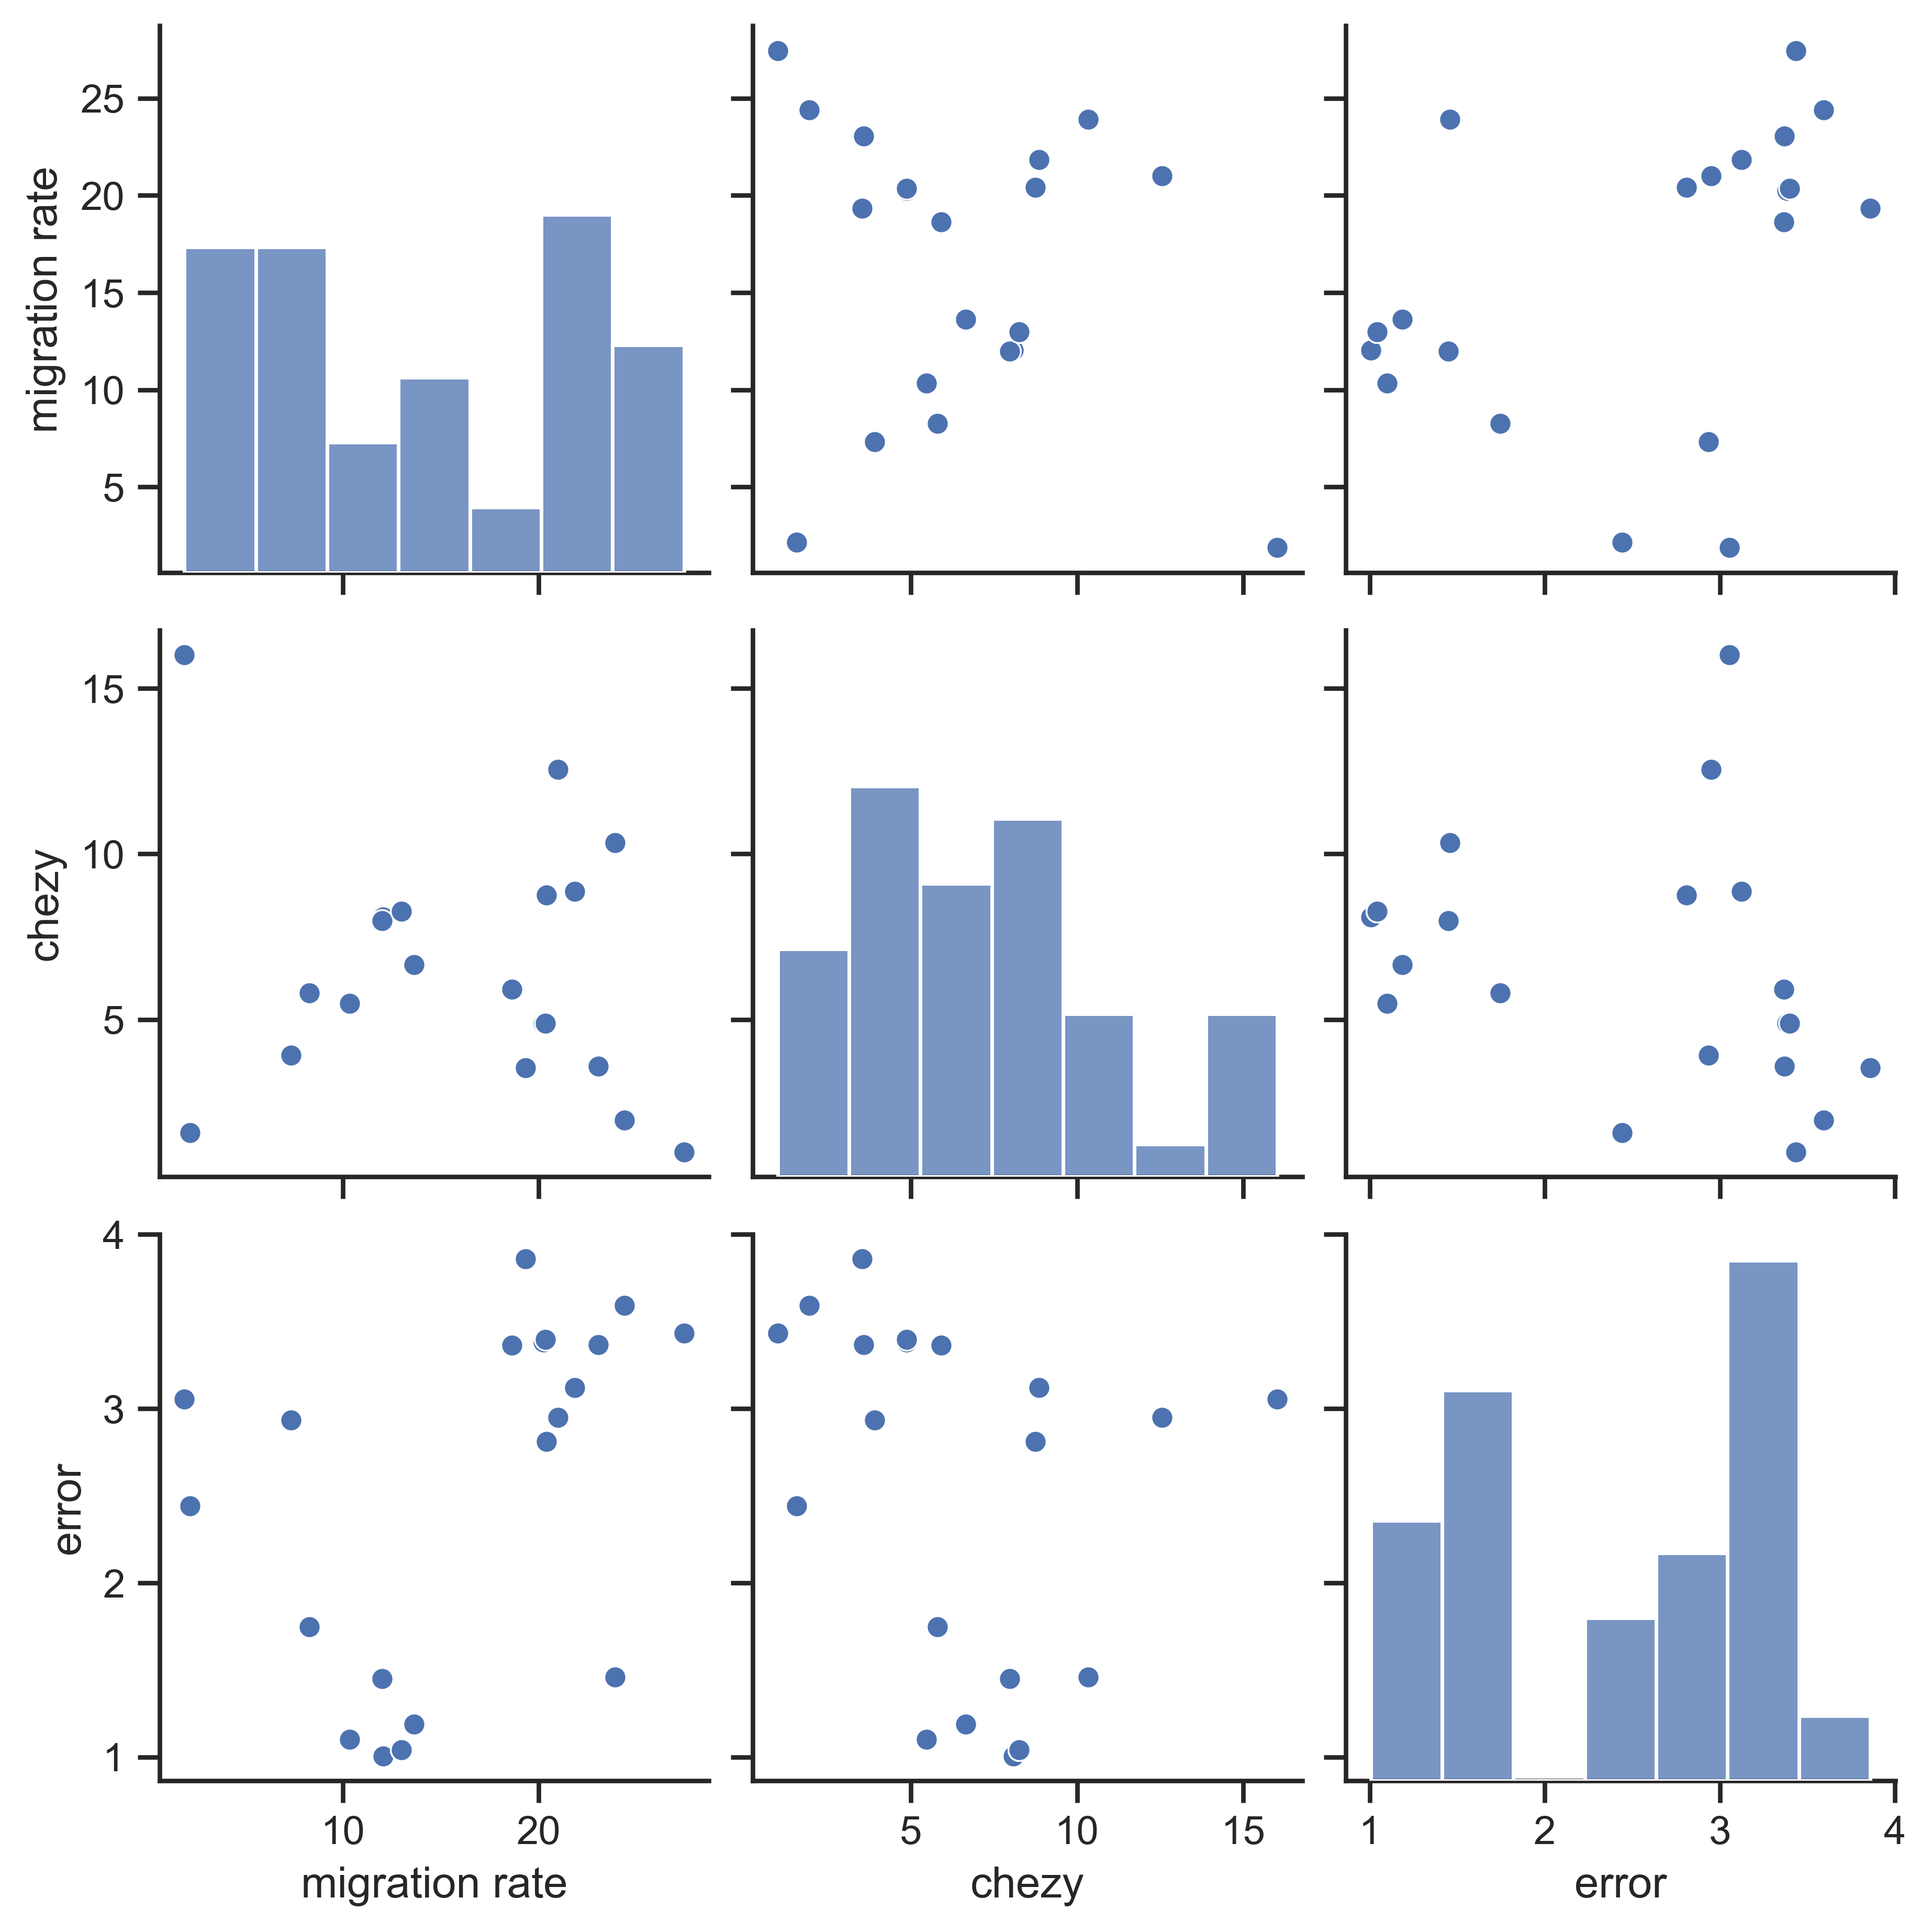

In [11]:
plt.rcParams.update({'font.size': 22}) # must set in top
samp_df = pd.DataFrame(samp2d)
samp_df = samp_df.rename(columns={0: 'migration rate',  1: 'chezy', 2: 'error'})   
samp_df
sns.color_palette("mako")
sns.set(style="ticks")
sns.pairplot(samp_df)

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1290.09it/s]
/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/2999998555.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.shape(0.1*chb.channels[np.int(nit-1)].x)[0] < 10000:
/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_38815/2999998555.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, yo

<Axes: title={'center': '5-year prediction for Ucayali River'}, xlabel='x', ylabel='y (--)'>

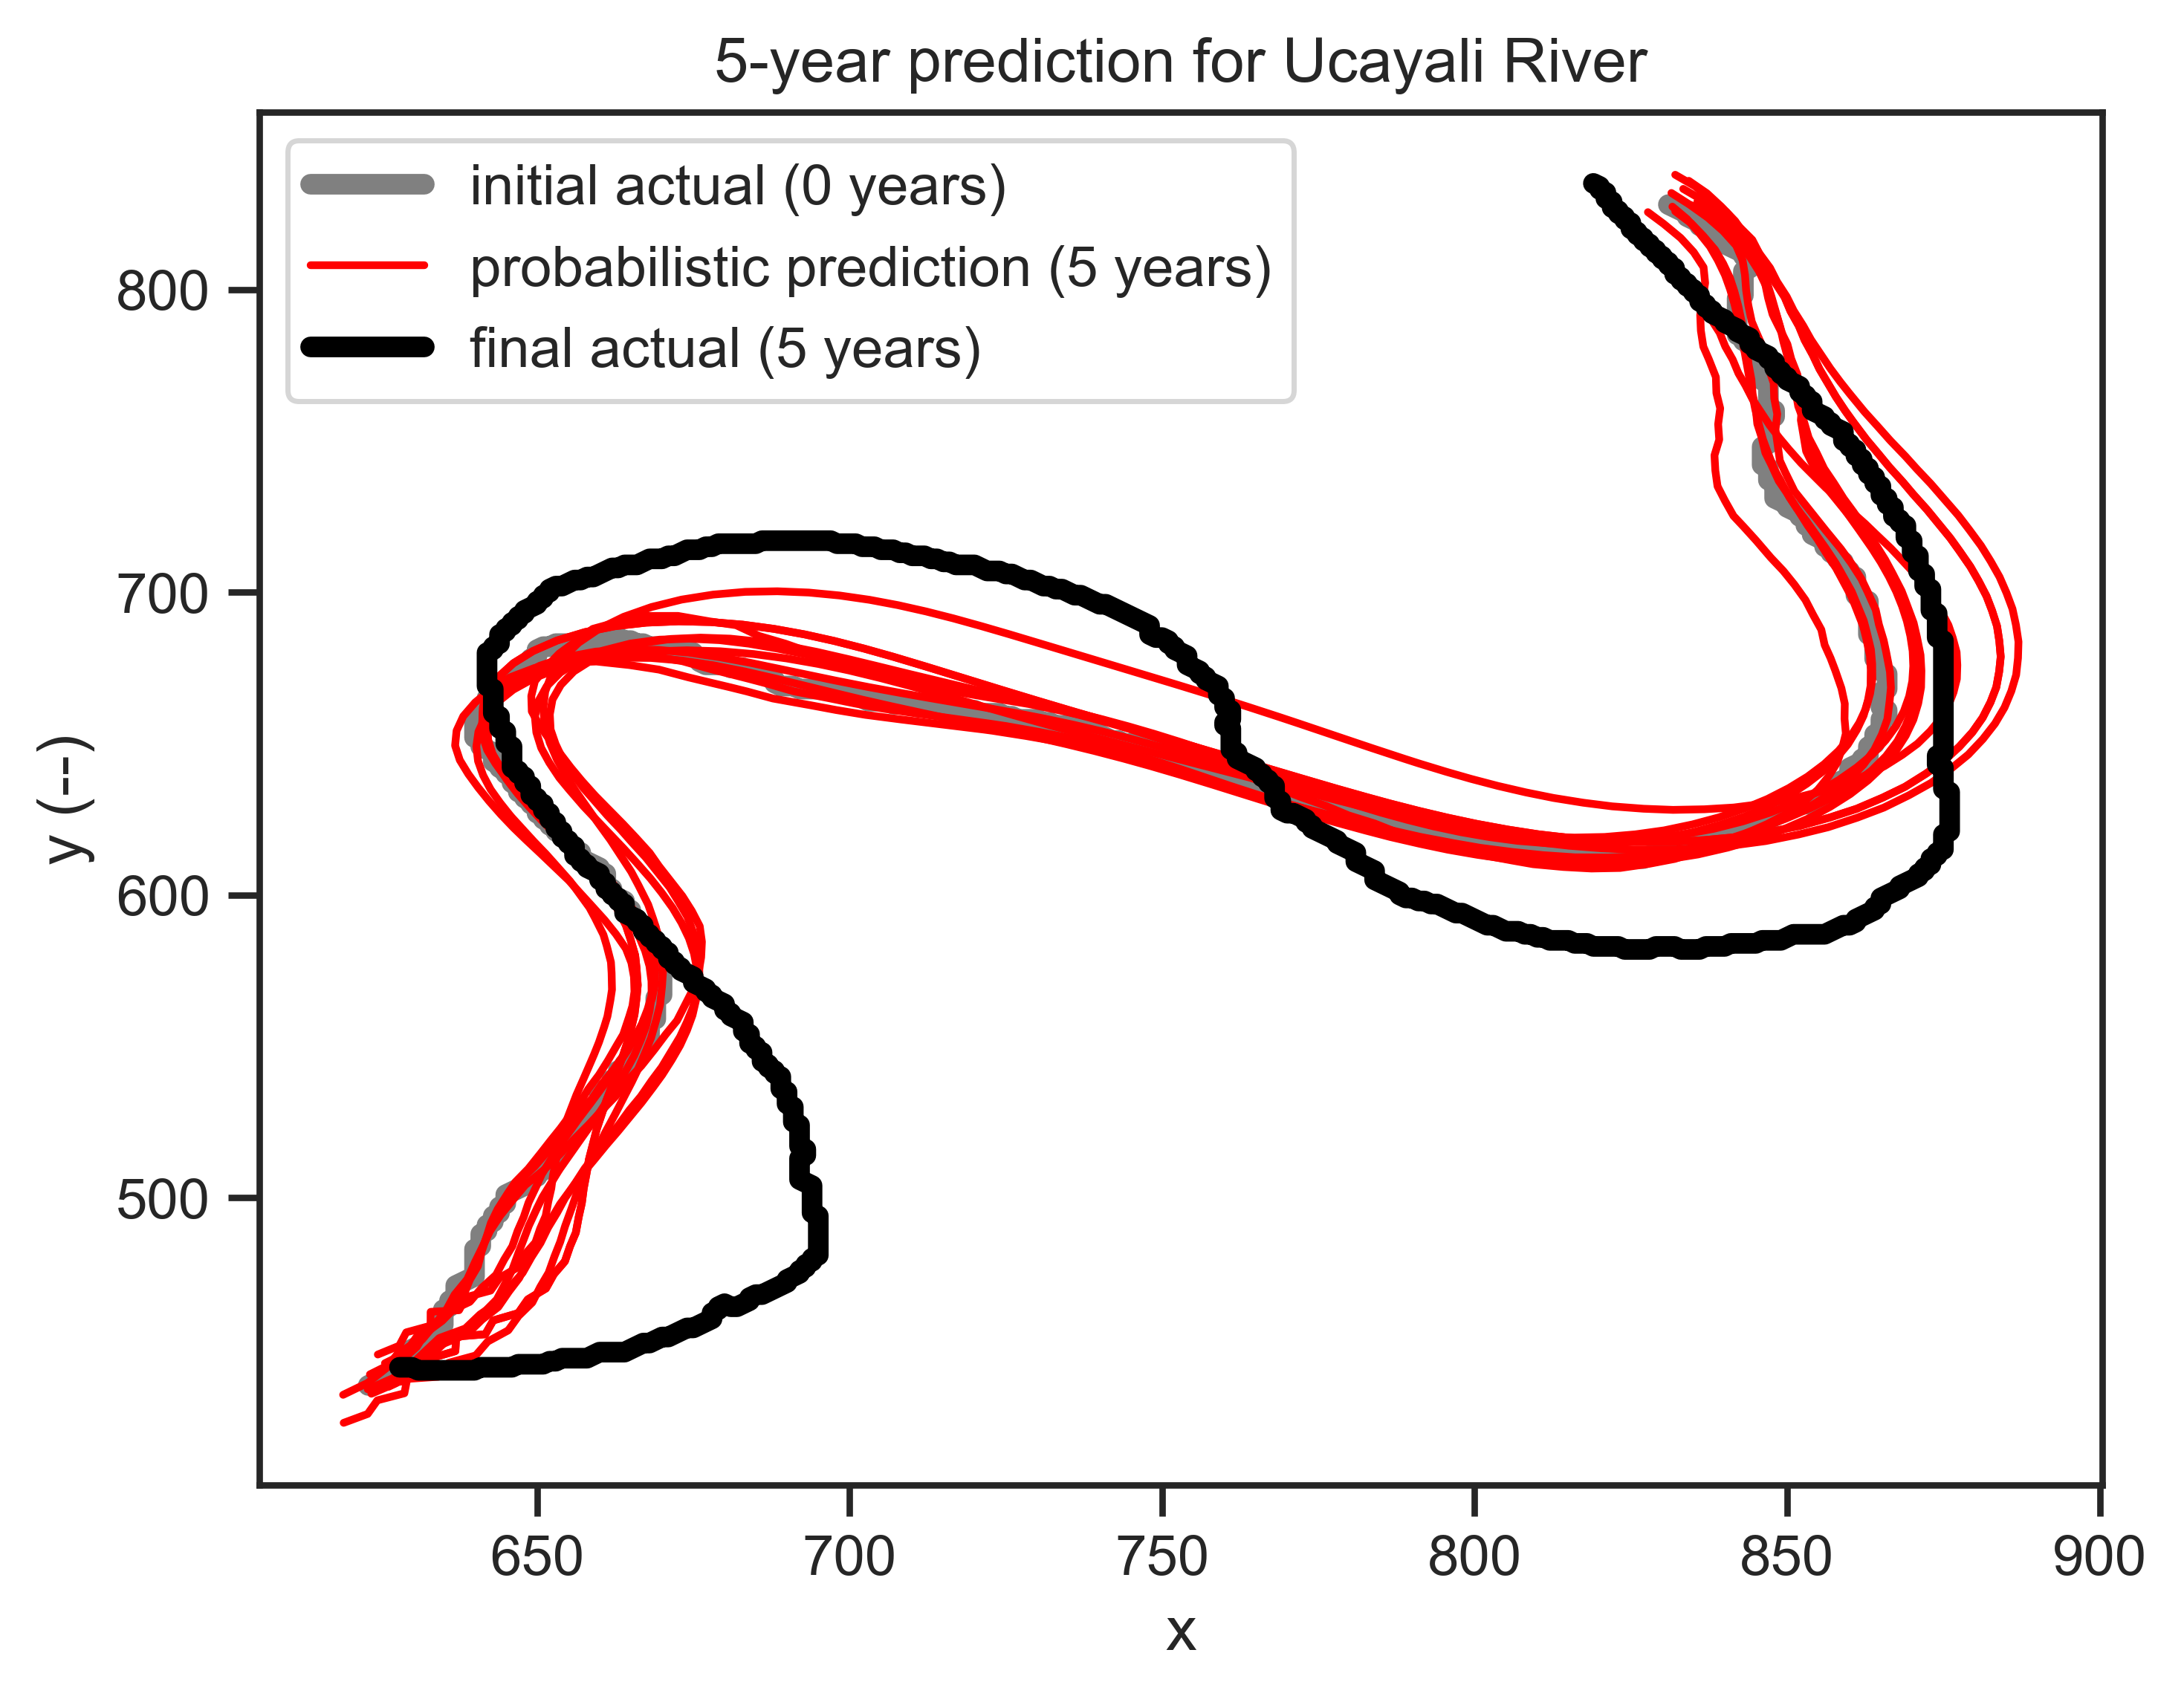

In [12]:
clin=-cl1+1000
clfi=-cl2+1000

t = np.linspace(0,1,np.shape(clin[:,])[0]) 
x_o = clin[:,1].flatten()          
y_o = clin[:,0].flatten()           
fx_o = interpolate.interp1d(t,x_o)     
fy_o = interpolate.interp1d(t, y_o)    
tnew = np.linspace(0,1,10000)                       
xnew_o = fx_o(tnew) + np.random.normal(0,0.2,10000) 
ynew_o = fy_o(tnew) + np.random.normal(0,0.2,10000) 
data_obs_ins = np.array([xnew_o,ynew_o])
data_obs_ins = np.round(data_obs_ins, 5) 
data_obs_ins = np.flip(data_obs_ins, axis=1)      

nit = 50                  
depths = D * np.ones((nit,)) 
pad = 0                 
deltas = 50.0               
crdist = 1.8 * W              
kv =  1.0e-12             
dt = 0.1*(365*24*60*60.0)    
dens = 1000               
saved_ts = 1              
n_bends = 5              
Sl = 0.0            
t1 = 0                  
t2 = 0                  
t3 = 0
          
def hkm_predict(parm):
    kl =  (parm[0]*10)/(365*24*60*60.0)     
    Cfs = parm[1]*0.001 * np.ones((nit,)) 
    y=cl1[:,0]*10
    x=cl1[:,1]*10
    z=np.zeros(len(x))
    H=depths[0]

    try:   
        ch=mp.Channel(-x,-y,z,W,H)
        chb=mp.ChannelBelt(channels=[ch], cutoffs=[], cl_times=[0.0], cutoff_times=[])
        ch = mp.generate_initial_channel(W,D,Sl,deltas,pad,n_bends) # initialize channel
        chb.migrate(nit,saved_ts,deltas,pad,crdist,depths,Cfs,kl,kv,dt,dens,t1,t2,t3,aggr_factor) # channel migration

        if np.shape(0.1*chb.channels[np.int(nit-1)].x)[0] < 10000:
            t = np.linspace(0,1,np.shape(0.1*chb.channels[np.int(nit-1)].x)[0])
            x_m = (0.1*chb.channels[np.int(nit-1)].x)+1000
            y_m = (0.1*chb.channels[np.int(nit-1)].y)+1000
            fx_m = interpolate.interp1d(t,x_m)
            fy_m = interpolate.interp1d(t, y_m)
            tnew = np.linspace(0,1,10000)
            xnew_m = fx_m(tnew)
            ynew_m = fy_m(tnew)
        
        else:
            t = np.linspace(0,1,10000)
            xnew_m = np.zeros(10000)
            ynew_m = np.zeros(10000)
    
    except:
        t = np.linspace(0,1,10000)
        xnew_m = np.zeros(10000)
        ynew_m = np.zeros(10000)
        
    return np.array( [xnew_m,ynew_m])

yss = np.zeros([10000,1000])
del_x = np.linspace(0,1,10000)
for i in range(0,1000):
    yss[:,i]= 1*(np.random.normal(0,1,1)*np.cos(2*np.pi*del_x)+np.random.normal(0,1,1)*np.sin(2*np.pi*del_x))
    
sc=1/1
counts = np.zeros((int(sc*800), int(sc*800)))     #create variables to store the information abt counts
prob = np.zeros((int(sc*800), int(sc*800)))       #create variables to store the information abt proability
counts_obs = np.zeros((int(sc*800),int(sc*800)))  #create variables to store the information abt counts
prob_obs = np.zeros((int(sc*800), int(sc*800)))   #create variables to store the information abt proability
ax = pd.DataFrame({"x":clin[:,1], "y":clin[:,0]}).plot.line(x='x', y='y', label='initial actual (0 years)', color='gray',lw=4)
ax.set_xlabel("x (--)")
ax.set_ylabel("y (--)")
ax.set_title("5-year prediction for Ucayali River")

for i in np.random.randint(0, 50, 10):
    samplenew = samp2d[i,:2]
    sim = hkm_predict(samplenew)
    erx = samp2d[i,2]*(np.random.normal(0,2,1)*np.cos(2*np.pi*del_x)+np.random.normal(0,2,1)*np.sin(2*np.pi*del_x))
    ery = samp2d[i,2]*(np.random.normal(0,2,1)*np.cos(2*np.pi*del_x)+np.random.normal(0,2,1)*np.sin(2*np.pi*del_x))
     # add the functions to HK model runs
    sim[0,:] = sim[0,:] + erx
    sim[1,:] = sim[1,:] + ery
    x = sim[0,:]
    y = sim[1,:]
    asdf = np.array([x,y])
    
    np.savetxt('samples_emcee.txt',asdf, delimiter=',')

    pd.DataFrame({"x":sim[0,:], "y":sim[1,:]}).plot.line(x='x', y='y', ax= ax, color='red',label='_Hidden')
    
    for j in range(0,int(sc*800)):
        # get the x-values of the river corresponding to the y-value of a certain
        # horizontal line
        idx = np.argwhere(np.diff(np.sign(sim[1,:] - np.arange(200,1000,1/sc)[j]))).flatten() 
        idx_obs = np.argwhere(np.diff(np.sign(data_obs_ins[1,:] - np.arange(200,1000,1/sc)[j]))).flatten() 
        
        #ax1.plot(x[idx], y[idx], 'ro')
        intersection = sim[0,idx]
        intersection_obs = data_obs_ins[0,idx_obs]
        
        #ax1.set_xticks(np.arange(-20, 21, 2))
        #ax1.set_yticks(np.arange(-20, 21, 2))   

        for k in range(0,int(sc*800)):
            # count the intersection points on the left side of the grid cell
            counts[k,j]= np.shape(intersection[intersection<=np.arange(200,1000,1/sc)[k]])[0]
            counts_obs[k,j]= np.shape(intersection_obs[intersection_obs<=np.arange(200,1000,1/sc)[k]])[0]
    
    counts = np.absolute(counts-counts_obs)
    #counts = (counts-counts_obs)
    counts[counts%2 == 1] = 1 # erosion happened i.e. = 1 if count number even
    counts[counts%2 == 0] = 0 # no erosion i.e. = 0 if count number off
    #counts[counts != 0] = 1 # erosion happened i.e. = 1 if count number even
    
    prob = prob + counts  # add up all the "monte carlo" runs that pass the grid cell
    
pd.DataFrame({"x":sim[0,:], "y":sim[1,:]}).plot.line(x='x', y='y', ax= ax, color='red',label="probabilistic prediction (5 years)")
pd.DataFrame({"x":clfi[:,1], "y":clfi[:,0]}).plot.line(x='x', y='y', ax= ax, label='final actual (5 years)',color='black',lw=4)

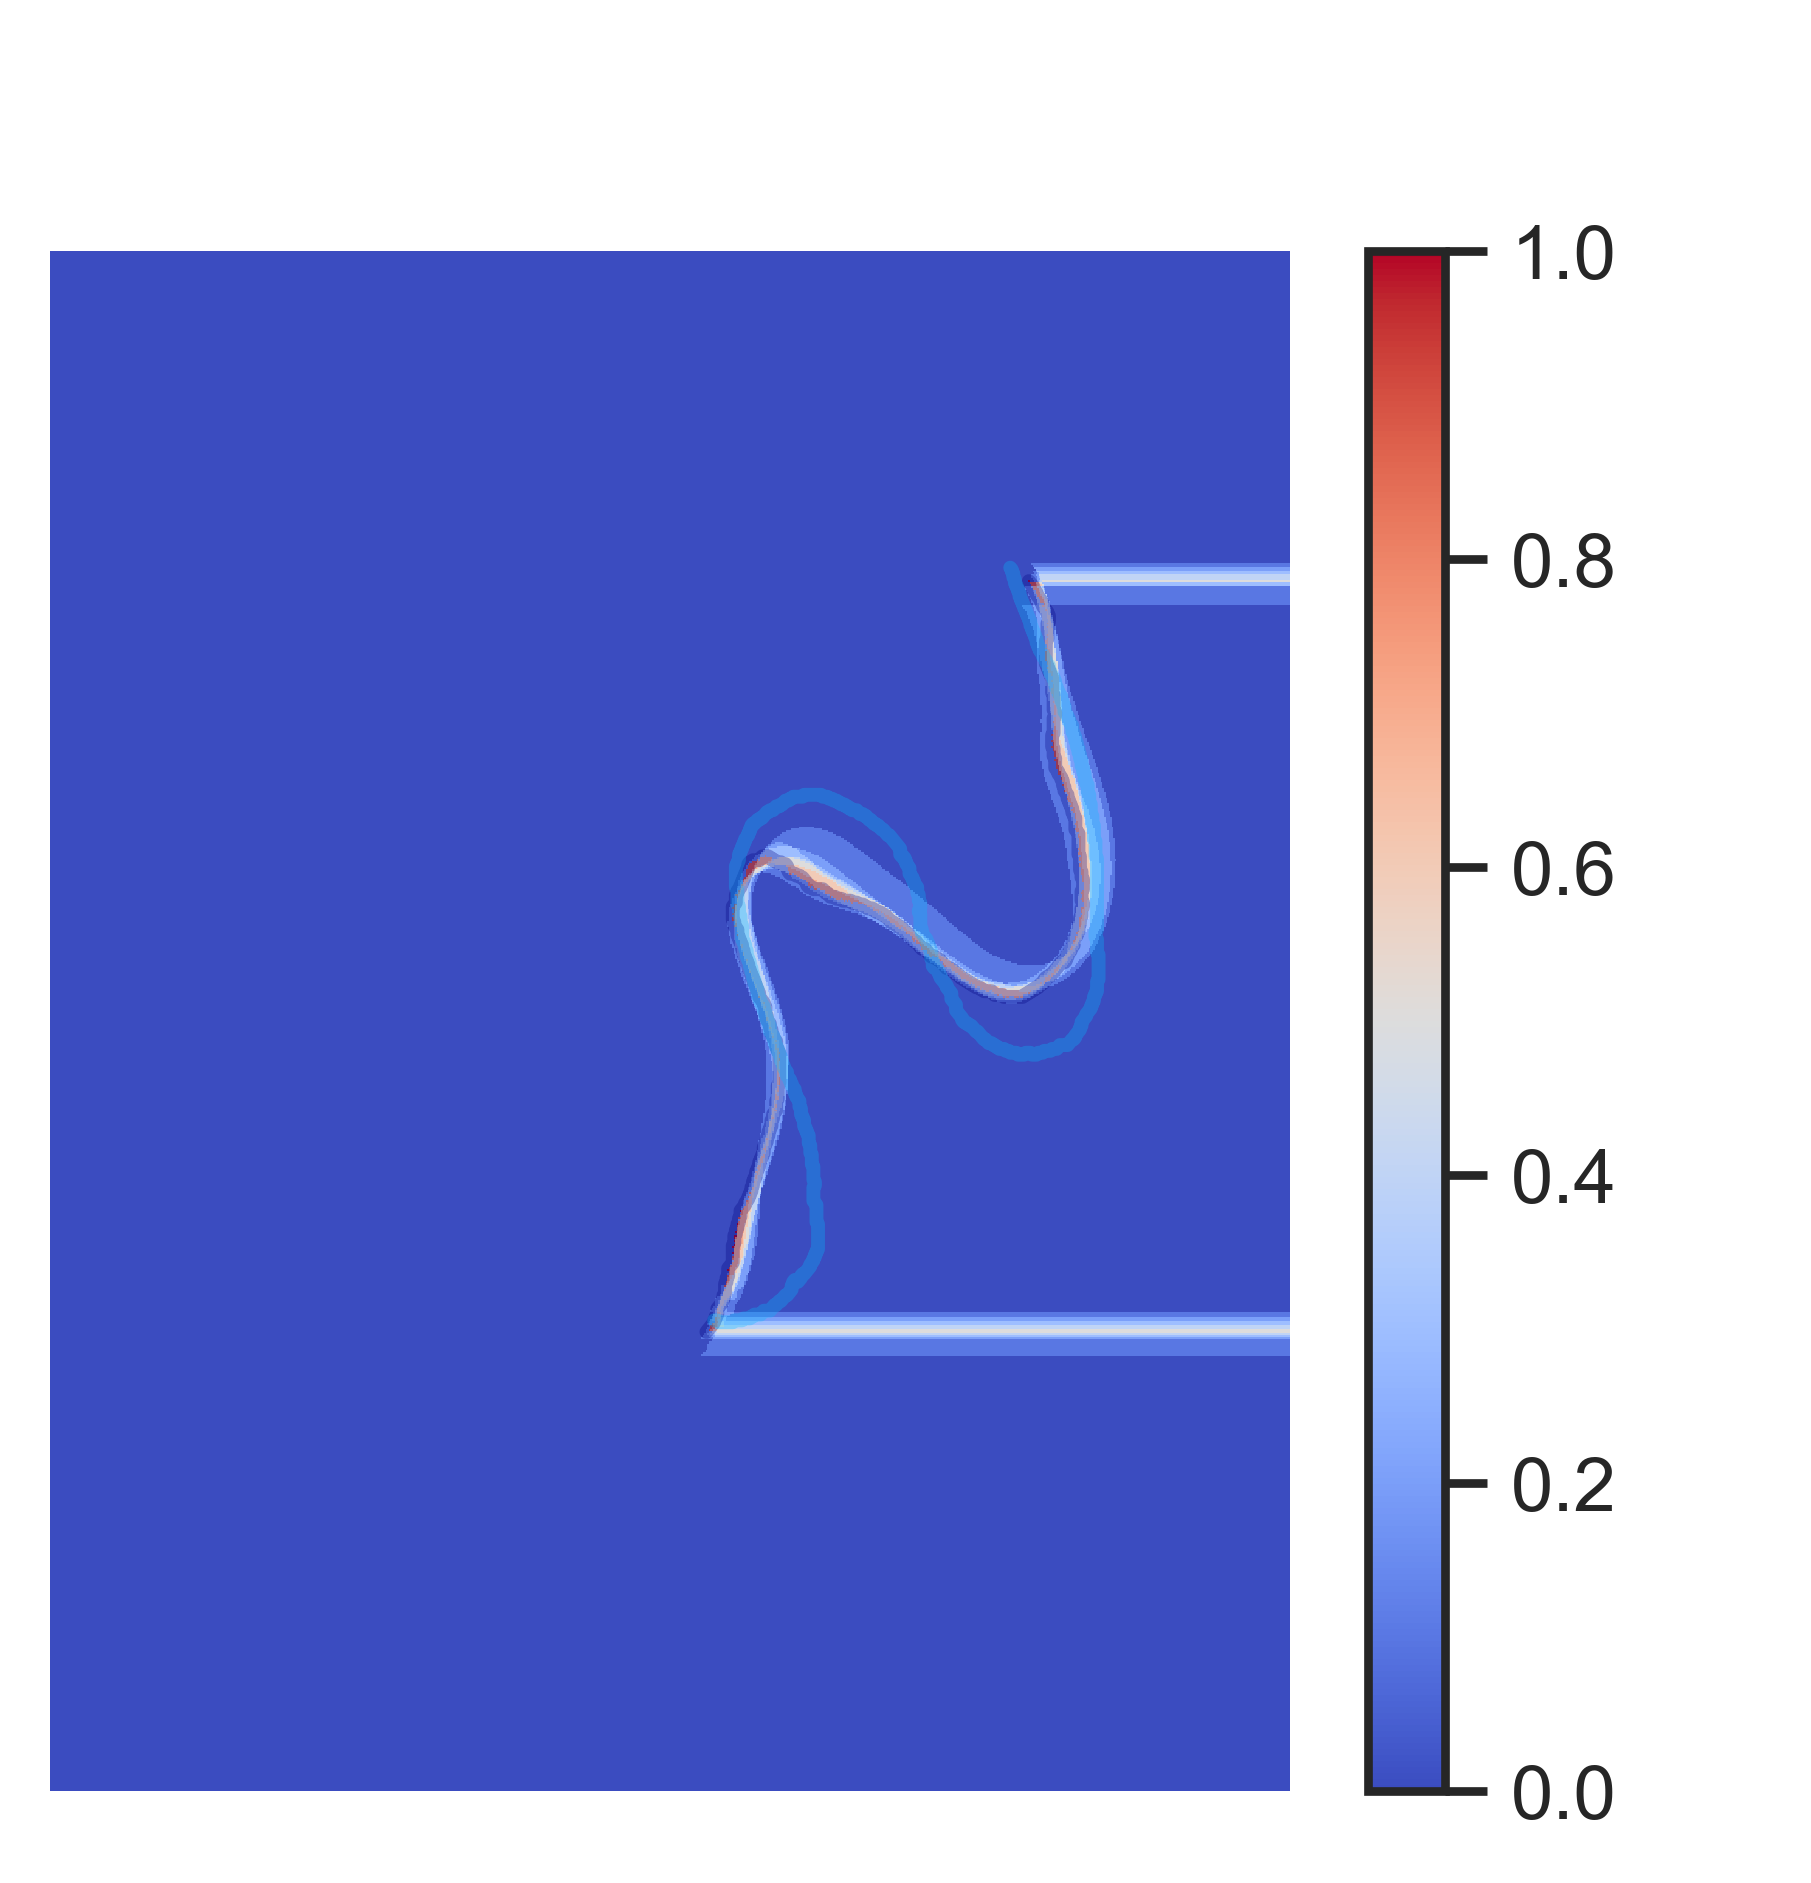

In [13]:
prob = prob/10
  
y, x = np.meshgrid(np.arange(0,800,1/sc), np.arange(0,800,1/sc))

z = prob

z_min, z_max = 0, np.abs(z).max()

fig, ax = plt.subplots(figsize=(4,4))

c = ax.pcolormesh(x, y, z, cmap="coolwarm", vmin=z_min, vmax=z_max)
fig.colorbar(c, ax=ax)
fig.legend('',frameon=False)
#plt.xlim([420, 760])
#plt.ylim([280, 620])

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "blue"})

d = z.ravel()
plt.axis('off')
pd.DataFrame({"x":-cl1[:,1]+800, "y":-cl1[:,0]+800}).plot.line(x='x', y='y', ax= ax,  color='navy',lw = 2,alpha=0.3,label='initial actual (0 years)')
pd.DataFrame({"x":-cl2[:,1]+800, "y":-cl2[:,0]+800}).plot.line(x='x', y='y',   color='#00BFFF',lw = 2,alpha=0.3,ax= ax,label='final actual (5 years)')
plt.legend(frameon=False,labelcolor='white',loc="upper left")
plt.legend('',frameon=False)